In [1]:
import numpy as np
import pandas as pd
import pathlib
import math

## functions used to remove duplicate company entries from the different company profile datasets; combines all profiles for one year into a single dataset
import ProcessDuplicates

# includes Interpolation function used in making time series
import useful_functions
from scipy.interpolate import interp1d

# main functions for cleaning, regression and initiating time series
import CDPCompanies_functions

# used in regression for data selection
from sklearn.linear_model import LinearRegression

dir_data = 'data/2023'

# importing PBL Current Policies scenario; annual change from this time series is used in interpolation step
PBL_CurrentPolicies = pd.read_excel(r''+dir_data+'/input/GP_CurPol.xlsx', sheet_name="data") 
PBL_CurrentPolicies_GlobalEmissions=PBL_CurrentPolicies.copy()
PBL_CurrentPolicies_GlobalEmissions = PBL_CurrentPolicies[(PBL_CurrentPolicies['Region']=="World") & (PBL_CurrentPolicies['Variable']=="Emissions|Kyoto Gases")]

annual_change_PBL_IMAGE=float(PBL_CurrentPolicies_GlobalEmissions['2030']/PBL_CurrentPolicies_GlobalEmissions['2020'])**(1/(1-(2030-2020)))-1

# SET YEARS OF DATASETS TO USE
years = ['2018', '2019', '2020', '2021', '2022']

<h2> Remove Duplicates from Input Files </h2>

In [3]:
# Run function to process duplicates in input data files by profile and data year
# Outputs single file per year with all profiles; used as input for next step
# ProcessDuplicates.main()

<h2> Apply Main Cleaning, Selection & Interpolation/Extrapolation Functions </h2>

In [5]:
## Loop that processes the single year files using imported functions by:
## 1) Cleaning the data
## 2) Combining inventory and target data
## 3) Selecting whether target or inventory data should be used for each company
## 4) Creating time series from each company's base year, MRY and target year emissions through interpolation

final_selections = []

all_series = []

mry_calc = 'mry_interpolate' ## 'mry_standard', 'mry_interpolate'

for year in years:
    ## clean all profile/year combos
    cleaned_combined = CDPCompanies_functions.company_import_cleaning(year, mry_calc)
    # cleaned_combined.to_excel(r''+dir_data+'/output/TESTING/NewScopeCalc_CleanedCombined_'+year+'.xlsx')
    if mry_calc == 'mry_standard':
        cleaned_combined.to_excel(r''+dir_data+'/output/Intermediate/CleanedCombined_'+year+'_MRYStandard.xlsx')
    elif mry_calc == 'mry_interpolate':
        cleaned_combined.to_excel(r''+dir_data+'/output/Intermediate/CleanedCombined_'+year+'_MRYInterpolation.xlsx')
    ## use regression to select whether the target or the inventory data is used for each company
    data_selected = CDPCompanies_functions.target_inventory_regression(cleaned_combined)
    # data_selected.to_excel(r''+dir_data+'/output/TESTING/NewScopeCalc_DataSelected_'+year+'.xlsx')
    if mry_calc == 'mry_standard':
        data_selected.to_excel(r''+dir_data+'/output/Intermediate/DataSelected_'+year+'_MRYStandard.xlsx')
    elif mry_calc == 'mry_interpolate':
        data_selected.to_excel(r''+dir_data+'/output/Intermediate/DataSelected_'+year+'_MRYInterpolation.xlsx')
    final_selections.append(data_selected)
    ## set parameters for the time series function
    extrapolation = 'PBL_IMAGE'
    last_milestone = '1990'
    ## create time series out of the selected data and interpolate between years
    year_series = CDPCompanies_functions.time_series(data_selected)
    # year_series.to_excel(r''+dir_data+'/output/TESTING/NewScopeCalc_TimeSeries'+year+'.xlsx')
    if mry_calc == 'mry_standard':
        year_series.to_excel(r''+dir_data+'/output/Intermediate/UncutTimeSeries_'+year+'_MRYStandard.xlsx')
    elif mry_calc == 'mry_interpolate':
        year_series.to_excel(r''+dir_data+'/output/Intermediate/UncutTimeSeries_'+year+'_MRYInterpolation.xlsx')
    year_columns = list(range(2018, 2051))
    info_columns = ['account_id', 'organization_target', 'profile', 'reporting_year', 'selected', 'nr_targets', 'base_year','target_year_1', 'targeted_reduction_1', 'target_year_2',
                   'targeted_reduction_2', 'target_year_3', 'targeted_reduction_3', 'target_year_4', 'targeted_reduction_4', 'target_year_5', 'targeted_reduction_5', 'by_em_final',
                    'mry_em_final', 'ty1_em_final', 'ty2_em_final', 'ty3_em_final', 'ty4_em_final', 'ty5_em_final']
    ## Only keep most relevant columns for the final time series appended to all_series list
    slice_columns = info_columns + year_columns
    ## return data frames with only the emissions time series and most relevant company information
    ## Cut time series for each reporting year down to only necessary columns and years 2020 - 2050
    all_series.append(year_series.loc[:,slice_columns])

    
    # if mry_calc == 'mry_standard':
    #     cleaned_combined.to_excel(r''+dir_data+'/output/OLD/Intermediate/CleanedCombined_'+year+'_MRYStandard.xlsx')
    #     data_selected.to_excel(r''+dir_data+'/output/OLD/Intermediate/DataSelected_'+year+'_MRYStandard.xlsx')
    #     year_series.to_excel(r''+dir_data+'/output/OLD/Intermediate/UncutTimeSeries_'+year+'_MRYStandard.xlsx')
    # elif mry_calc == 'mry_interpolate':
    #     cleaned_combined.to_excel(r''+dir_data+'/output/OLD/Intermediate/CleanedCombined_'+year+'_MRYInterpolation.xlsx')
    #     data_selected.to_excel(r''+dir_data+'/output/OLD/Intermediate/DataSelected_'+year+'_MRYInterpolation.xlsx')
    #     year_series.to_excel(r''+dir_data+'/output/OLD/Intermediate/UncutTimeSeries_'+year+'_MRYInterpolation.xlsx')

In [6]:
## Check the number of data frames produced
## Should equal number of years from top of script 

len(all_series)

5

<h2> Check company counts after each processing step </h2>

In [2]:
# Count number of companies in each data set for input files

# input_years = []

# for year in years:
#     input_prof1 = pd.read_excel(r''+dir_data+'/input/IKEA_NSA_abs_er_'+year+'_prof1_vF.xlsx', sheet_name='Sheet 1')
#     input_prof2 = pd.read_excel(r''+dir_data+'/input/IKEA_NSA_abs_er_'+year+'_prof2_vF.xlsx', sheet_name='Sheet 1')
#     input_prof4 = pd.read_excel(r''+dir_data+'/input/IKEA_NSA_abs_er_'+year+'_prof4_vF.xlsx', sheet_name='Sheet 1')
#     input_list = [input_prof1, input_prof2, input_prof4]
#     input_concat = pd.concat(input_list, ignore_index=True)
#     input_years.append(input_concat)
    
# input_rows = []

# for x in input_years:
#     input_rows.append(x.shape[0])

In [4]:
# Count number of companies in each data set after removing duplicate entries for companies

# processed_years = []

# for year in years:
#     processed = pd.read_excel(r''+dir_data+'/processed/IKEA_NSA_abs_er_'+year+'_vF.xlsx', sheet_name='Sheet 1')
#     processed_years.append(processed)
    
# processduplicates_rows = []

# for x in processed_years:
#     processduplicates_rows.append(x.shape[0])

In [7]:
# Count number of companies in each data set after cleaning and combining

# cleanedcombined = []

# for year in years:
#     cc = pd.read_excel(r''+dir_data+'/output/Intermediate/CleanedCombined_'+year+'_MRYInterpolation.xlsx')
#     cleanedcombined.append(cc)
    
# cc_rows = []

# for x in cleanedcombined:
#     cc_rows.append(x.shape[0])

In [8]:
# Count number of companies in each data set after data selection regression step

# dataselected_rows = []

# for x in final_selections:
#     dataselected_rows.append(x.shape[0])

In [9]:
# Create dataframe with total company counts in each dataset after different processing steps

# company_counts = pd.DataFrame()

# company_counts['Input Rows'] = input_rows
# company_counts['Post ProcessDuplicates'] = processduplicates_rows
# company_counts['Post CleanedCombined'] = cc_rows
# company_counts['Post Data Selection'] = dataselected_rows

# df_index = pd.Index(years)

# company_counts.set_index(df_index, inplace=True)

# company_counts.to_excel(r''+dir_data+'/output/Intermediate/CompanyCounts.xlsx')

<h2> All Companies Processing </h2>

In [13]:
## Sort companies by account id in prep for next steps
for s in all_series:
    s.sort_values(by=['account_id'])

In [14]:
## Sum emissions from all companies in each year; divide by 1000000 to convert to Mt
## This is used as the basis for the ambition pathways
for a in all_series:
    a.loc['Total'] = a.loc[:,2018:2050].sum(axis=0).div(1000000)

In [15]:
## Export time series 2018 - 2050 for each reporting year
for (a, year) in zip(all_series, years):
    if mry_calc == 'mry_standard':
        a.to_excel(r''+dir_data+'/output/Final/ALL_TimeSeries_'+year+'_MRYStandard.xlsx')
    elif mry_calc == 'mry_interpolate':
        a.to_excel(r''+dir_data+'/output/Final/ALL_TimeSeries_'+year+'_MRYInterpolation.xlsx')
    # if mry_calc == 'mry_standard':
    #     a.to_excel(r''+dir_data+'/output/OLD/Final/ALL_TimeSeries_'+year+'_MRYStandard.xlsx')
    # elif mry_calc == 'mry_interpolate':
    #     a.to_excel(r''+dir_data+'/output/OLD/Final/ALL_TimeSeries_'+year+'_MRYInterpolation.xlsx')

<h3> Check Top 10 from each dataset </h3>

In [10]:
## Select the top 10 companies from each data set in terms of base year emissions and mry emissions
# top10_by = []
# top10_mry = []

# for x in final_selections:
#     top_by = x.nlargest(n=10, columns=['by_em_final'])
#     top_mry = x.nlargest(n=10, columns=['mry_em_final'])
#     top10_by.append(top_by[['account_id','organization_target', 'selected', 'by_em_final']])
#     top10_mry.append(top_mry[['account_id', 'organization_target', 'selected', 'mry_em_final']])

In [11]:
## Export top 10 companies OVERALL, REGARDLESS OF SECTOR in terms of base year emissions for each reporting year
# if mry_calc == 'mry_standard':
#     with pd.ExcelWriter(r''+dir_data+'/output/Intermediate/Top10_BY_STANDARD.xlsx') as writer:
#         for i in range(len(years)):
#             top10_by[i].to_excel(writer, sheet_name=str(years[i]))
# elif mry_calc == 'mry_interpolate':
#     with pd.ExcelWriter(r''+dir_data+'/output/Intermediate/Top10_BY_INTERPOLATE.xlsx') as writer:
#         for i in range(len(years)):
#             top10_by[i].to_excel(writer, sheet_name=str(years[i]))

In [12]:
## Export top 10 companies OVERALL, REGARDLESS OF SECTOR in terms of mry emissions for each reporting year
# if mry_calc == 'mry_standard':
#     with pd.ExcelWriter(r''+dir_data+'/output/Intermediate/Top10_MRY_STANDARD.xlsx') as writer:
#         for i in range(len(years)):
#             top10_mry[i].to_excel(writer, sheet_name=str(years[i]))
# elif mry_calc == 'mry_interpolate':
#     with pd.ExcelWriter(r''+dir_data+'/output/Intermediate/Top10_MRY_INTERPOLATE.xlsx') as writer:
#         for i in range(len(years)):
#             top10_mry[i].to_excel(writer, sheet_name=str(years[i]))

<h2> Overlapping Companies Processing </h2>

In [16]:
## Filter out overlapping companies (companies who reported in all reporting years)

## from: https://statisticsglobe.com/merge-list-pandas-dataframes-python
from functools import reduce
overlapping_companies = reduce(lambda left, right:    
                    pd.merge(left , right,
                             on = ["account_id"],  
                             how = "inner"),
                    all_series)

overlapping_list = list(overlapping_companies['account_id'])

overlapping_series = []

for s in all_series:
    overlapping = s[s['account_id'].isin(overlapping_list)]
    overlapping_series.append(overlapping)

C:\Users\Jones020\AppData\Local\Temp\ipykernel_10744\3234881070.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'targeted_reduction_1_x', 'targeted_reduction_5_x', '2038_x', 'organization_target_x', 'targeted_reduction_4_x', '2018_x', 'ty3_em_final_x', '2036_x', '2049_x', 'mry_em_final_x', '2019_x', '2045_x', 'target_year_4_x', 'target_year_1_x', 'selected_x', '2034_x', '2032_x', '2048_x', '2027_x', 'ty2_em_final_x', '2050_x', 'reporting_year_x', 'targeted_reduction_2_x', '2020_x', '2047_x', '2033_x', '2022_x', '2028_x', '2029_x', '2039_x', 'target_year_3_x', '2026_x', '2025_x', 'profile_x', 'ty4_em_final_x', '2043_x', 'target_year_2_x', 'ty5_em_final_x', 'base_year_x', 'by_em_final_x', '2035_x', 'target_year_5_x', '2046_x', 'nr_targets_x', '2031_x', 'ty1_em_final_x', '2041_x', '2042_x', 'targeted_reduction_3_x', '2021_x', '2024_x', '2037_x', '2044_x', '2030_x', '2023_x', '2040_x'} in the result is deprecated and will raise a MergeError in a future version.
  pd.

In [20]:
## check for duplicate account ids in all reporting years
for s in all_series:
    print(s[s['account_id'].duplicated(keep=False)])

Empty DataFrame
Columns: [account_id, organization_target, profile, reporting_year, selected, nr_targets, base_year, target_year_1, targeted_reduction_1, target_year_2, targeted_reduction_2, target_year_3, targeted_reduction_3, target_year_4, targeted_reduction_4, target_year_5, targeted_reduction_5, by_em_final, mry_em_final, ty1_em_final, ty2_em_final, ty3_em_final, ty4_em_final, ty5_em_final, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050]
Index: []

[0 rows x 57 columns]
Empty DataFrame
Columns: [account_id, organization_target, profile, reporting_year, selected, nr_targets, base_year, target_year_1, targeted_reduction_1, target_year_2, targeted_reduction_2, target_year_3, targeted_reduction_3, target_year_4, targeted_reduction_4, target_year_5, targeted_reduction_5, by_em_final, mry_em_final, ty1_em_final, ty2_em_final, ty3_em_final,

In [21]:
## Sum emissions from overlapping companies in each year; divide by 1000000 to convert to Mt
for o in overlapping_series:
    o.loc['Total'] = o.loc[:,2018:2050].sum(axis=0).div(1000000)

In [22]:
## Export time series from each reporting year for overlapping companies
for (o, year) in zip(overlapping_series, years):
    if mry_calc == 'mry_standard':
        o.to_excel(r''+dir_data+'/output/Final/OV_TimeSeries_'+year+'_MRYStandard.xlsx')
    elif mry_calc == 'mry_interpolate':
        o.to_excel(r''+dir_data+'/output/Final/OV_TimeSeries_'+year+'_MRYInterpolation.xlsx')
    # if mry_calc == 'mry_standard':
    #     o.to_excel(r''+dir_data+'/output/OLD/Final/OV_TimeSeries_'+year+'_MRYStandard.xlsx')
    # elif mry_calc == 'mry_interpolate':
    #     o.to_excel(r''+dir_data+'/output/OLD/Final/OV_TimeSeries_'+year+'_MRYInterpolation.xlsx')

<h3> Check Top 10 from each dataset </h3>

In [17]:
# ov_top10_by = []
# ov_top10_mry = []

# for i in overlapping_series:
#     top_by = i.nlargest(n=10, columns=['by_em_final'])
#     top_mry = i.nlargest(n=10, columns=['mry_em_final'])
#     ov_top10_by.append(top_by[['account_id','organization_target', 'selected', 'by_em_final']])
#     ov_top10_mry.append(top_mry[['account_id', 'organization_target', 'selected', 'mry_em_final']])

In [18]:
## Export top 10 companies OVERALL, REGARDLESS OF SECTOR in terms of base year emissions for each reporting year
# if mry_calc == 'mry_standard':
#     with pd.ExcelWriter(r''+dir_data+'/output/Intermediate/OVTop10_BY_STANDARD.xlsx') as writer:
#         for i in range(len(years)):
#             ov_top10_by[i].to_excel(writer, sheet_name=str(years[i]))
# elif mry_calc == 'mry_interpolate':
#     with pd.ExcelWriter(r''+dir_data+'/output/Intermediate/OVTop10_BY_INTERPOLATE.xlsx') as writer:
#         for i in range(len(years)):
#             ov_top10_by[i].to_excel(writer, sheet_name=str(years[i]))

In [19]:
## Export top 10 companies OVERALL, REGARDLESS OF SECTOR in terms of mry emissions for each reporting year
# if mry_calc == 'mry_standard':
#     with pd.ExcelWriter(r''+dir_data+'/output/Intermediate/OVTop10_MRY_STANDARD.xlsx') as writer:
#         for i in range(len(years)):
#             ov_top10_mry[i].to_excel(writer, sheet_name=str(years[i]))
# elif mry_calc == 'mry_interpolate':
#     with pd.ExcelWriter(r''+dir_data+'/output/Intermediate/OVTop10_MRY_INTERPOLATE.xlsx') as writer:
#         for i in range(len(years)):
#             ov_top10_mry[i].to_excel(writer, sheet_name=str(years[i]))

<h2> Ambition Pathways Graph </h2>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


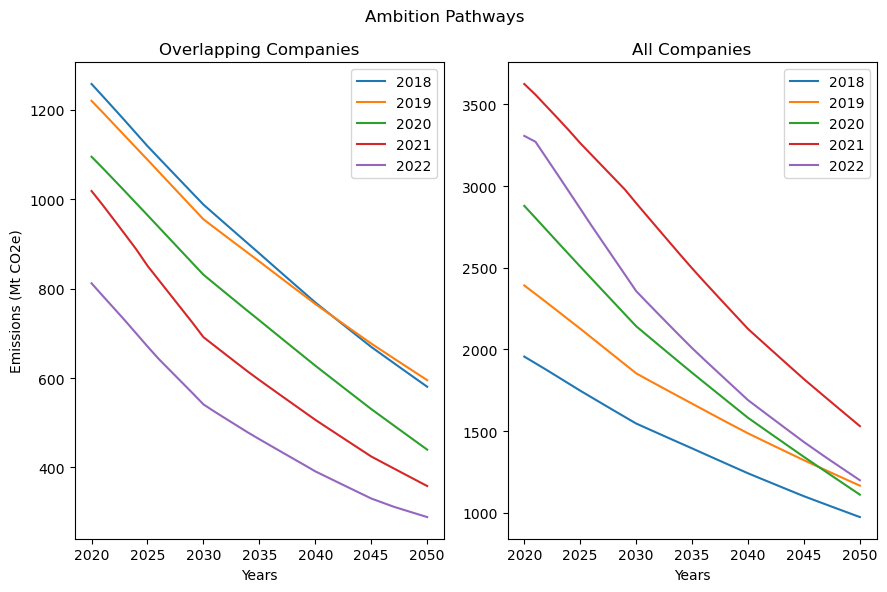

In [23]:
## VISUALISATION OF AMBITION PATHWAYS

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 6))
fig.suptitle('Ambition Pathways')

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


x = list(range(2020, 2051))
legend_years = ['2018', '2019', '2020', '2021', '2022']
y = overlapping_series
z = all_series
for i in range(len(y)):
    ## Plot OVERLAPPING companies
    ax1.plot(x, y[i].loc['Total', 2020:2050], label=legend_years[i])
    ## Plot ALL companies
    ax2.plot(x, z[i].loc['Total', 2020:2050], label=legend_years[i])

ax1.legend()
ax2.legend()

ax1.title.set_text('Overlapping Companies')
ax1.set_ylabel('Emissions (Mt CO2e)')
ax1. set_xlabel('Years')
ax2.title.set_text('All Companies')
ax2.set_xlabel('Years')

fig.tight_layout()

# plt.savefig(r''+dir_data+'/output/TESTING/NewScopeCalc_AP.png')

if mry_calc == 'mry_standard':
    plt.savefig(r''+dir_data+'/output/Figures/NEW_AmbitionPathways_MRYStandard.png')
elif mry_calc == 'mry_interpolate':
    plt.savefig(r''+dir_data+'/output/Figures/NEW_AmbitionPathways_MRYInterpolation.png')
    plt.savefig(r''+dir_data+'/output/ForDesigner/AmbitionPathways.eps', format='eps')

<h3> Export Excel files for designer </h3>

In [24]:
## Export Excel files for designer
ap_all_data = []

for i in range(len(legend_years)):
    data = z[i].loc['Total', 2020:2050]
    ap_all_data.append(data)
    
ap_ov_data = []

for i in range(len(legend_years)):
    data = y[i].loc['Total', 2020:2050]
    ap_ov_data.append(data)

In [25]:
ap_all = pd.concat(ap_all_data, axis=1)
ap_ov = pd.concat(ap_ov_data, axis=1)

In [26]:
ap_all.columns = [legend_years]
ap_ov.columns = [legend_years]

In [27]:
with pd.ExcelWriter(r''+dir_data+'/output/ForDesigner/AmbitionPathways.xlsx') as writer:
    ap_all.to_excel(writer, sheet_name='All Companies')
    ap_ov.to_excel(writer, sheet_name='Overlapping Companies')

<h2> IEA Sector Mapping </h2>

In [28]:
all_sectors = []


## Mapping of 'Primary activity' values from C5 Emissions Methodology sheets to IEA sectors: Chemical and petrochemical, Iron and steel or Non-metallic minerals
sector_mapping = {'Iron & steel': 'Iron and steel',  'Basic plastics':'Chemical and petrochemical', 'Agricultural chemicals':'Chemical and petrochemical', 'Inorganic base chemicals':'Chemical and petrochemical', 
                  'Specialty chemicals':'Chemical and petrochemical', 'Other base chemicals':'Chemical and petrochemical', 'Oil & gas refining':'Chemical and petrochemical', 
                  'Glass products':'Non-metallic minerals', 'Cement':'Non-metallic minerals', 'Other non-metallic minerals':'Non-metallic minerals', 'Ceramics':'Non-metallic minerals'}

# import C5_EmissionsMethodology files for all relevant years
for year in years:
    ## THE C5 EMISSIONS FILES WERE TRASNFERRED TO THE '20221014/INPUT' FOLDER
    c5_file = pd.read_excel(r''+dir_data+'/input/C5_EmissionsMethodology_'+year+'.xlsx')
    c5_file.rename(columns={'Account number':'account_id'}, inplace=True)
    c5_file.sort_values(by=['account_id'])
    c5_crop = c5_file[['account_id','Organization','Primary activity', 'Primary sector', 'Primary industry']]
    # c5_crop['IEA sector'] = c5_crop['Primary sector'].map(sector_mapping, na_action='ignore')
    c5_crop['IEA sector'] = c5_crop['Primary activity'].map(sector_mapping, na_action='ignore')
    all_sectors.append(c5_crop)

<h3> Overlapping Companies Sector Mapping </h3>

In [29]:
ovcompanies_industryagg = []

ovcompanies_sectoragg = []

ovcompanies_sectorlist = []

## Will apply the 2018 primary activity/IEA sector and primary industry classifications from each company for consistency
## (Otherwise the same companies change these designations over reporting years, confounding results)

c5_2018 = all_sectors[0]

# attach c5_EmissionsMethodology to respective time series, by year, FOR OVERLAPPING COMPANIES
for x in overlapping_series:
    ## merge 2018 C5 classification scheme to each year's time series data
    industry_merge = x.merge(c5_2018, how='left', on='account_id')
    ovcompanies_sectorlist.append(industry_merge)
    ## group by Primary industry, as defined by CDP
    industry_agg = industry_merge.groupby(by=['Primary industry']).sum().loc[:,2020:2050].div(1000000)
    ## add columns to calculate summary stats
    industry_agg.loc['Total'] = industry_agg.sum(axis=0)
    percent_change = industry_agg.loc[:,2020:2050].pct_change(axis=1)
    industry_agg.loc['Annual Percentage Change'] = percent_change.loc['Total']*100
    
    ovcompanies_industryagg.append(industry_agg)
    
    ## group by assigned IEA sector, according to IEA sector mapping
    sector_agg = industry_merge.groupby(by=['IEA sector']).sum().loc[:,2020:2050].div(1000000)
    ## add columns to calculate summary stats
    sector_agg.loc['Total'] = sector_agg.sum(axis=0)
    percent_change = sector_agg.loc[:,2020:2050].pct_change(axis=1)
    sector_agg.loc['Annual Percentage Change'] = percent_change.loc['Total']*100
    
    ovcompanies_sectoragg.append(sector_agg)

C:\Users\Jones020\AppData\Local\Temp\ipykernel_10744\1458809183.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  industry_agg = industry_merge.groupby(by=['Primary industry']).sum().loc[:,2020:2050].div(1000000)
C:\Users\Jones020\AppData\Local\Temp\ipykernel_10744\1458809183.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sector_agg = industry_merge.groupby(by=['IEA sector']).sum().loc[:,2020:2050].div(1000000)
C:\Users\Jones020\AppData\Local\Temp\ipykernel_10744\1458809183.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only

In [34]:
# Output industry aggregated emissions for OVERLAPPING companies
for (il, year) in zip(ovcompanies_industryagg, years):
    if mry_calc == 'mry_standard':
        il.to_excel(r''+dir_data+'/output/Final/IndustryAgg_OV'+year+'_MRYStandard.xlsx')
    elif mry_calc == 'mry_interpolate':
        il.to_excel(r''+dir_data+'/output/Final/IndustryAgg_OV'+year+'_MRYInterpolation.xlsx')

for (sl, year) in zip(ovcompanies_sectoragg, years):
    if mry_calc == 'mry_standard':
        sl.to_excel(r''+dir_data+'/output/Final/IEASectorAgg_OV_'+year+'_MRYStandard.xlsx')
    elif mry_calc == 'mry_interpolate':
        sl.to_excel(r''+dir_data+'/output/Final/IEASectorAgg_OV_'+year+'_MRYInterpolation.xlsx')
        
# for (il, year) in zip(ovcompanies_industryagg, years):
#     if mry_calc == 'mry_standard':
#         il.to_excel(r''+dir_data+'/output/OLD/Final/IndustryAgg_OV'+year+'_MRYStandard.xlsx')
#     elif mry_calc == 'mry_interpolate':
#         il.to_excel(r''+dir_data+'/output/OLD/Final/IndustryAgg_OV'+year+'_MRYInterpolation.xlsx')

# for (sl, year) in zip(ovcompanies_sectoragg, years):
#     if mry_calc == 'mry_standard':
#         sl.to_excel(r''+dir_data+'/output/OLD/Final/IEASectorAgg_OV_'+year+'_MRYStandard.xlsx')
#     elif mry_calc == 'mry_interpolate':
#         sl.to_excel(r''+dir_data+'/output/OLD/Final/IEASectorAgg_OV_'+year+'_MRYInterpolation.xlsx')

<h4> Check Top 10 </h4>

In [30]:
## Select top 10 companies in each sector, in each year, in terms of by and mry emissions, for OVERLAPPING companies
# ov_sectors_topby = []
# ov_sectors_topmry = []

# for i in ovcompanies_sectorlist:
#     for s in ['Chemical and petrochemical', 'Iron and steel', 'Non-metallic minerals']:
#         i_s = i[i['IEA sector'] == s]
#         top_by = i_s[['account_id', 'selected', 'by_em_final', 'IEA sector']].nlargest(n=10, columns=['by_em_final'])
#         top_mry = i_s[['account_id', 'selected', 'mry_em_final', 'IEA sector']].nlargest(n=10, columns=['mry_em_final'])
#         ov_sectors_topby.append(top_by)
#         ov_sectors_topmry.append(top_mry)

In [31]:
## Concatenate top for each sector together by year

# ts_by_2018 = pd.concat(ov_sectors_topby[0:3])
# ts_by_2019 = pd.concat(ov_sectors_topby[3:6])
# ts_by_2020 = pd.concat(ov_sectors_topby[6:9])
# ts_by_2021 = pd.concat(ov_sectors_topby[9:12])
# ts_by_2022 = pd.concat(ov_sectors_topby[12:15])

# ts_mry_2018 = pd.concat(ov_sectors_topmry[0:3])
# ts_mry_2019 = pd.concat(ov_sectors_topmry[3:6])
# ts_mry_2020 = pd.concat(ov_sectors_topmry[6:9])
# ts_mry_2021 = pd.concat(ov_sectors_topmry[9:12])
# ts_mry_2022 = pd.concat(ov_sectors_topmry[12:15])

In [32]:
## Export top 10 companies PER SECTOR for OVERLAPPING companies in terms of base year emissions for each reporting year
# if mry_calc == 'mry_standard':
#     with pd.ExcelWriter(r''+dir_data+'/output/Intermediate/Top10_OVSECTORS_BY_STANDARD.xlsx') as writer:
#         ts_by_2018.to_excel(writer, sheet_name='2018')
#         ts_by_2019.to_excel(writer, sheet_name='2019')
#         ts_by_2020.to_excel(writer, sheet_name='2020')
#         ts_by_2021.to_excel(writer, sheet_name='2021')
#         ts_by_2022.to_excel(writer, sheet_name='2022')
# if mry_calc == 'mry_interpolate':
#     with pd.ExcelWriter(r''+dir_data+'/output/Intermediate/Top10_OVSECTORS_BY_INTERPOLATE.xlsx') as writer:
#         ts_by_2018.to_excel(writer, sheet_name='2018')
#         ts_by_2019.to_excel(writer, sheet_name='2019')
#         ts_by_2020.to_excel(writer, sheet_name='2020')
#         ts_by_2021.to_excel(writer, sheet_name='2021')
#         ts_by_2022.to_excel(writer, sheet_name='2022')

In [33]:
## Export top 10 companies PER SECTOR for OVERLAPPING companies in terms of mry emissions for each reporting year
# if mry_calc == 'mry_standard':
#     with pd.ExcelWriter(r''+dir_data+'/output/Intermediate/Top10_OVSECTORS_MRY_STANDARD.xlsx') as writer:
#         ts_mry_2018.to_excel(writer, sheet_name='2018')
#         ts_mry_2019.to_excel(writer, sheet_name='2019')
#         ts_mry_2020.to_excel(writer, sheet_name='2020')
#         ts_mry_2021.to_excel(writer, sheet_name='2021')
#         ts_mry_2022.to_excel(writer, sheet_name='2022')
# if mry_calc == 'mry_interpolate':
#     with pd.ExcelWriter(r''+dir_data+'/output/Intermediate/Top10_OVSECTORS_MRY_INTERPOLATE.xlsx') as writer:
#         ts_mry_2018.to_excel(writer, sheet_name='2018')
#         ts_mry_2019.to_excel(writer, sheet_name='2019')
#         ts_mry_2020.to_excel(writer, sheet_name='2020')
#         ts_mry_2021.to_excel(writer, sheet_name='2021')
#         ts_mry_2022.to_excel(writer, sheet_name='2022')

<h3> All Companies Sector Mapping </h3>

In [35]:
allcompanies_industryagg = []

allcompanies_sectoragg = []

allcompanies_sectorlist = []

## attach c5_EmissionsMethodology to respective time series, by year, FOR ALL COMPANIES
for x, c5 in zip(all_series, all_sectors):
    ## merge C5 classification scheme to each year's time series data
    industry_merge = x.merge(c5, how='left', on='account_id')
    allcompanies_sectorlist.append(industry_merge)
    ## group by Primary industry, as defined by CDP
    industry_agg = industry_merge.groupby(by=['Primary industry']).sum().loc[:,2020:2050].div(1000000)
    ## add columns to calculate summary stats
    # industry_agg.loc[:, 'No. of companies reporting'] = c5.loc[:,'Primary industry'].value_counts()
    industry_agg.loc['Total'] = industry_agg.sum(axis=0)
    percent_change = industry_agg.loc[:,2020:2050].pct_change(axis=1)
    industry_agg.loc['Annual Percentage Change'] = percent_change.loc['Total']*100
    
    allcompanies_industryagg.append(industry_agg)
    
    ## group by assigned sector, according to IEA sector mapping
    sector_agg = industry_merge.groupby(by=['IEA sector']).sum().loc[:,2020:2050].div(1000000)
    ## add columns to calculate summary stats
    # sector_agg.loc[:, 'No. of companies reporting'] = c5.loc[:,'IEA sector'].value_counts()
    sector_agg.loc['Total'] = sector_agg.sum(axis=0)
    sector_change = sector_agg.loc[:,2020:2050].pct_change(axis=1)
    sector_agg.loc['Total Annual Percentage Change'] = sector_change.loc['Total']*100
    sector_agg.loc['C&P Annual Percentage Change'] = sector_change.loc['Chemical and petrochemical']*100
    sector_agg.loc['I&S Annual Percentage Change'] = sector_change.loc['Iron and steel']*100
    sector_agg.loc['NM Annual Percentage Change'] = sector_change.loc['Non-metallic minerals']*100
    
    allcompanies_sectoragg.append(sector_agg)

C:\Users\Jones020\AppData\Local\Temp\ipykernel_10744\3626021899.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  industry_agg = industry_merge.groupby(by=['Primary industry']).sum().loc[:,2020:2050].div(1000000)
C:\Users\Jones020\AppData\Local\Temp\ipykernel_10744\3626021899.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sector_agg = industry_merge.groupby(by=['IEA sector']).sum().loc[:,2020:2050].div(1000000)
C:\Users\Jones020\AppData\Local\Temp\ipykernel_10744\3626021899.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only

In [36]:
## Output industry and IEA sector aggregated emissions for ALL companies as inidividual files
for (il, year) in zip(allcompanies_industryagg, years):
    if mry_calc == 'mry_standard':
        il.to_excel(r''+dir_data+'/output/Final/IndustryAgg_ALL_'+year+'_MRYStandard.xlsx')
    elif mry_calc == 'mry_interpolate':
        il.to_excel(r''+dir_data+'/output/Final/IndustryAgg_ALL_'+year+'_MRYInterpolation.xlsx')

for (sl, year) in zip(allcompanies_sectoragg, years):
    if mry_calc == 'mry_standard':
        sl.to_excel(r''+dir_data+'/output/Final/IEASectorAgg_ALL_'+year+'_MRYStandard.xlsx')
    elif mry_calc == 'mry_interpolate':
        sl.to_excel(r''+dir_data+'/output/Final/IEASectorAgg_ALL_'+year+'_MRYInterpolation.xlsx')
        
# for (il, year) in zip(allcompanies_industryagg, years):
#     if mry_calc == 'mry_standard':
#         il.to_excel(r''+dir_data+'/output/OLD/Final/IndustryAgg_ALL_'+year+'_MRYStandard.xlsx')
#     elif mry_calc == 'mry_interpolate':
#         il.to_excel(r''+dir_data+'/output/OLD/Final/IndustryAgg_ALL_'+year+'_MRYInterpolation.xlsx')

# for (sl, year) in zip(allcompanies_sectoragg, years):
#     if mry_calc == 'mry_standard':
#         sl.to_excel(r''+dir_data+'/output/OLD/Final/IEASectorAgg_ALL_'+year+'_MRYStandard.xlsx')
#     elif mry_calc == 'mry_interpolate':
#         sl.to_excel(r''+dir_data+'/output/OLD/Final/IEASectorAgg_ALL_'+year+'_MRYInterpolation.xlsx')

<h4> Check Top 10 </h4>

In [37]:
## Select top 10 companies in each sector, in each year, in terms of by and mry emissions, for ALL companies
# all_sectors_topby = []
# all_sectors_topmry = []

# for i in allcompanies_sectorlist:
#     for s in ['Chemical and petrochemical', 'Iron and steel', 'Non-metallic minerals']:
#         i_s = i[i['IEA sector'] == s]
#         top_by = i_s[['account_id', 'selected', 'by_em_final', 'IEA sector']].nlargest(n=10, columns=['by_em_final'])
#         top_mry = i_s[['account_id', 'selected', 'mry_em_final', 'IEA sector']].nlargest(n=10, columns=['mry_em_final'])
#         all_sectors_topby.append(top_by)
#         all_sectors_topmry.append(top_mry)

In [38]:
## Concatenate top companies for each sector together by year (3 sectors per year)
# ta_by_2018 = pd.concat(all_sectors_topby[0:3])
# ta_by_2019 = pd.concat(all_sectors_topby[3:6])
# ta_by_2020 = pd.concat(all_sectors_topby[6:9])
# ta_by_2021 = pd.concat(all_sectors_topby[9:12])
# ta_by_2022 = pd.concat(all_sectors_topby[12:15])

# ta_mry_2018 = pd.concat(all_sectors_topmry[0:3])
# ta_mry_2019 = pd.concat(all_sectors_topmry[3:6])
# ta_mry_2020 = pd.concat(all_sectors_topmry[6:9])
# ta_mry_2021 = pd.concat(all_sectors_topmry[9:12])
# ta_mry_2022 = pd.concat(all_sectors_topmry[12:15])

In [39]:
## Export top 10 companies from ALL companies PER SECTOR in terms of base year emissions for each reporting year
# if mry_calc == 'mry_standard':
#     with pd.ExcelWriter(r''+dir_data+'/output/Intermediate/Top10_ALLSECTORS_BY_STANDARD.xlsx') as writer:
#         ta_by_2018.to_excel(writer, sheet_name='2018')
#         ta_by_2019.to_excel(writer, sheet_name='2019')
#         ta_by_2020.to_excel(writer, sheet_name='2020')
#         ta_by_2021.to_excel(writer, sheet_name='2021')
#         ta_by_2022.to_excel(writer, sheet_name='2022')
# elif mry_calc == 'mry_interpolate':
#     with pd.ExcelWriter(r''+dir_data+'/output/Intermediate/Top10_ALLSECTORS_BY_INTERPOLATE.xlsx') as writer:
#         ta_by_2018.to_excel(writer, sheet_name='2018')
#         ta_by_2019.to_excel(writer, sheet_name='2019')
#         ta_by_2020.to_excel(writer, sheet_name='2020')
#         ta_by_2021.to_excel(writer, sheet_name='2021')
        # ta_by_2022.to_excel(writer, sheet_name='2022')

In [40]:
## Export top 10 companies from ALL companies PER SECTOR in terms of mry emissions for each reporting year
# if mry_calc == 'mry_standard':
#     with pd.ExcelWriter(r''+dir_data+'/output/Intermediate/Top10_ALLSECTORS_MRY_STANDARD.xlsx') as writer:
#         ta_mry_2018.to_excel(writer, sheet_name='2018')
#         ta_mry_2019.to_excel(writer, sheet_name='2019')
#         ta_mry_2020.to_excel(writer, sheet_name='2020')
#         ta_mry_2021.to_excel(writer, sheet_name='2021')
#         ta_mry_2022.to_excel(writer, sheet_name='2022')
# elif mry_calc == 'mry_interpolate':
#     with pd.ExcelWriter(r''+dir_data+'/output/Intermediate/Top10_ALLSECTORS_MRY_INTERPOLATE.xlsx') as writer:
#         ta_mry_2018.to_excel(writer, sheet_name='2018')
#         ta_mry_2019.to_excel(writer, sheet_name='2019')
#         ta_mry_2020.to_excel(writer, sheet_name='2020')
#         ta_mry_2021.to_excel(writer, sheet_name='2021')
#         ta_mry_2022.to_excel(writer, sheet_name='2022')

<h2> Export Combined Final Datasets </h2>

In [41]:
## Output all companies in each year with assigned IEA sector
## Outputs to Excel file with each year as a separate sheet within the file

sectors = ['Chemical and petrochemical', 'Iron and steel', 'Non-metallic minerals']

with pd.ExcelWriter(r''+dir_data+'/output/ALLCOMPANIES_IEASECTORS.xlsx') as writer:
    for i in range(len(allcompanies_sectorlist)):
        for s in sectors:
            allcompanies_sectorlist[i][allcompanies_sectorlist[i]['IEA sector'] == s].to_excel(writer, sheet_name=years[i])

In [42]:
## Calculate average annual change for different IEA sectors by year

cp_change = []
is_change = []
nm_change = []

sectorchange_avg = pd.DataFrame(index=years, columns=['C&P', 'I&S', 'NM'])

for x in allcompanies_sectoragg:
    cp = x.loc['C&P Annual Percentage Change'].mean()
    cp_change.append(cp)
    i_s = x.loc['I&S Annual Percentage Change'].mean()
    is_change.append(i_s)
    nm = x.loc['NM Annual Percentage Change'].mean()
    nm_change.append(nm)
    
sectorchange_avg['C&P'] = cp_change
sectorchange_avg['I&S'] = is_change
sectorchange_avg['NM'] = nm_change


In [43]:
## Calculate average annual change for each year's aggregated ambition pathway

for (x, o) in zip(all_series, overlapping_series):
    all_pct = x.loc[:,2020:2050].pct_change(axis=1)
    ov_pct = o.loc[:,2020:2050].pct_change(axis=1)
    x.loc['Annual Percentage Change'] = all_pct.loc['Total']*100
    o.loc['Annual Percentage Change'] = ov_pct.loc['Total']*100

annualchange_avg = pd.DataFrame(index=years, columns=['Overlapping Companies', 'All Companies'])

all_change = []
ov_change = []

for i in range(len(years)):
    ac = all_series[i].loc['Annual Percentage Change'].mean()
    oc = overlapping_series[i].loc['Annual Percentage Change'].mean()
    all_change.append(ac)
    ov_change.append(oc)
    

annualchange_avg['Overlapping Companies'] = ov_change

annualchange_avg['All Companies'] = all_change


In [98]:
data_a = []
data_o = []

## Take emissions values from ambition pathways at key years and convert to GIGATONNES
for (a, o) in zip(all_series, overlapping_series):
    em_a = a.loc['Total',[2020,2030,2040,2050]].div(1000)
    data_a.append(em_a)
    em_o = o.loc['Total',[2020,2030,2040,2050]].div(1000)
    data_o.append(em_o)

In [99]:
em_all = pd.DataFrame(data=data_a,index=years)
em_ov = pd.DataFrame(data=data_o,index=years)

for f in [em_all, em_ov]:
    f.loc[:, 'Percent Change 2020 - 2050'] = ((f.loc[:, 2020] - f.loc[:, 2050])/f.loc[:, 2020])*100

In [100]:
## Output aggregated ambition pathways for all companies IEA sector, with separate sheets by year
        
with pd.ExcelWriter(r''+dir_data+'/output/Combined_AmbitionPathways.xlsx') as writer:
    annualchange_avg.to_excel(writer, sheet_name='Average Annual Change by Year')
    em_all.to_excel(writer, sheet_name='EmissionsSnapshot_AllCompanies')
    em_ov.to_excel(writer, sheet_name='EmissionsSnapshot_OVCompanies')
    for i in range(len(all_series)):           
        all_series[i].to_excel(writer, sheet_name='ALL_'+years[i])
    for i in range(len(overlapping_series)):
        overlapping_series[i].to_excel(writer, sheet_name='OV_'+years[i])

<h2> Create Target & Annual Reduction Tables: All & Overlapping Companies </h2>

In [47]:
## Functions to calculat annual reductions for different target categories based on distance from disclosure year

def annual_reductions_short(frame, year):
    
    t0 = int(year)
    T = int(year) + 5
    EM_t0 = frame.loc['Total', t0]
    EM_T = frame.loc['Total', T]
    annual_reduction = -1*((EM_T/EM_t0)**(1/(T-t0))-1)
    
    return annual_reduction*100

def annual_reductions_medium(frame, year):
    
    t0 = int(year) + 6
    T = int(year) + 15
    EM_t0 = frame.loc['Total', t0]
    EM_T = frame.loc['Total', T]
    annual_reduction = -1*((EM_T/EM_t0)**(1/(T-t0))-1)
    
    return annual_reduction*100

def annual_reductions_long(frame, year):
    
    t0 = int(year) + 16
    T = 2050
    EM_t0 = frame.loc['Total', t0]
    EM_T = frame.loc['Total', T]
    annual_reduction = -1*((EM_T/EM_t0)**(1/(T-t0))-1)
    
    return annual_reduction*100

In [48]:
ar_short = []
ar_medium = []
ar_long = []

for (a, y) in zip(all_series, years):
    ars = annual_reductions_short(a, y)
    arm = annual_reductions_medium(a, y)
    arl = annual_reductions_long(a, y)
    ar_short.append(ars)
    ar_medium.append(arm)
    ar_long.append(arl)
    
ser_list = []
for x in [ar_short, ar_medium, ar_long]:
    ser = pd.Series(x, index=years)
    ser_list.append(ser)
    
summary_table_all = pd.concat(ser_list, axis=1, keys=['Annual Reduction Short-term Targets', 'Annual Reduction Medium-term Targets', 'Annual Reduction Long-term Targets'])

In [49]:
or_short = []
or_medium = []
or_long = []

for (o, y) in zip(overlapping_series, years):
    ors = annual_reductions_short(o, y)
    orm = annual_reductions_medium(o, y)
    orl = annual_reductions_long(o, y)
    or_short.append(ors)
    or_medium.append(orm)
    or_long.append(orl)
    
ser2_list = []
for x in [or_short, or_medium, or_long]:
    ser2 = pd.Series(x, index=years)
    ser2_list.append(ser2)
    
summary_table_ov = pd.concat(ser2_list, axis=1, keys=['Annual Reduction Short-term Targets', 'Annual Reduction Medium-term Targets', 'Annual Reduction Long-term Targets'])

In [50]:
## Create summary tables of companies/targets for all companies and number of companies/targets for overlapping companies in each reporting year

for (s, year) in zip(all_series, years):
    summary_table_all.loc[year, 'Total companies'] = s.shape[0]
    summary_table_all.loc[year, 'Total targets'] = s['nr_targets'].sum()
    ## Target length is defined as follows:
    ## Short targets: targets where the target year is listed as being between the disclosure year and 5 years later than the discloure year
    ## Medium targets: targets where the target year is listed as being between 6 and 15 years later than the disclosure year
    ## Long targets: targets where the target year is listed as being greater than 15 years later than the disclosure year
            
    summary_table_all.loc[year, 'N_Short targets'] = (s['target_year_1'].between(int(year),int(year)+5, inclusive='both').sum() + 
                                                    s['target_year_2'].between(int(year),int(year)+5, inclusive='both').sum() +
                                                    s['target_year_3'].between(int(year),int(year)+5, inclusive='both').sum() +
                                                    s['target_year_4'].between(int(year),int(year)+5, inclusive='both').sum() +
                                                    s['target_year_5'].between(int(year),int(year)+5, inclusive='both').sum())
    summary_table_all.loc[year, 'N_Medium targets'] = (s['target_year_1'].between(int(year)+6,int(year)+15, inclusive='both').sum() + 
                                                    s['target_year_2'].between(int(year)+6,int(year)+15, inclusive='both').sum() +
                                                    s['target_year_3'].between(int(year)+6,int(year)+15, inclusive='both').sum() +
                                                    s['target_year_4'].between(int(year)+6,int(year)+15, inclusive='both').sum() +
                                                    s['target_year_5'].between(int(year)+6,int(year)+15, inclusive='both').sum())
    summary_table_all.loc[year, 'N_Long targets'] = ((s['target_year_1'] > int(year)+15).sum() + 
                                                   (s['target_year_2'] > int(year)+15).sum() +
                                                   (s['target_year_3'] > int(year)+15).sum() +
                                                   (s['target_year_4'] > int(year)+15).sum() +
                                                   (s['target_year_5'] > int(year)+15).sum())
    

        
for (o, year) in zip (overlapping_series, years):
    summary_table_ov.loc[year, 'Total companies'] = o.shape[0]
    summary_table_ov.loc[year, 'Total targets'] = o['nr_targets'].sum()
    
    summary_table_ov.loc[year, 'Short targets'] = (o['target_year_1'].between(int(year),int(year)+5, inclusive='both').sum() + 
                                                    o['target_year_2'].between(int(year),int(year)+5, inclusive='both').sum() +
                                                    o['target_year_3'].between(int(year),int(year)+5, inclusive='both').sum() +
                                                    o['target_year_4'].between(int(year),int(year)+5, inclusive='both').sum() +
                                                    o['target_year_5'].between(int(year),int(year)+5, inclusive='both').sum())
    summary_table_ov.loc[year, 'Medium targets'] = (o['target_year_1'].between(int(year)+6,int(year)+15, inclusive='both').sum() + 
                                                    o['target_year_2'].between(int(year)+6,int(year)+15, inclusive='both').sum() +
                                                    o['target_year_3'].between(int(year)+6,int(year)+15, inclusive='both').sum() +
                                                    o['target_year_4'].between(int(year)+6,int(year)+15, inclusive='both').sum() +
                                                    o['target_year_5'].between(int(year)+6,int(year)+15, inclusive='both').sum())
    summary_table_ov.loc[year, 'Long targets'] = ((o['target_year_1'] > int(year)+15).sum() + 
                                                   (o['target_year_2'] > int(year)+15).sum() +
                                                   (o['target_year_3'] > int(year)+15).sum() +
                                                   (o['target_year_4'] > int(year)+15).sum() +
                                                   (o['target_year_5'] > int(year)+15).sum())
    


In [51]:
## Expoprt summary tables to Excel files

if mry_calc == 'mry_standard':
    summary_table_all.to_excel(r''+dir_data+'/output/Final/SummaryTable_ALL_MRYStandard.xlsx')
    summary_table_ov.to_excel(r''+dir_data+'/output/Final/SummaryTable_OV_MRYStandard.xlsx')
elif mry_calc == 'mry_interpolate':
    summary_table_all.to_excel(r''+dir_data+'/output/Final/SummaryTable_ALL_MRYInterpolate.xlsx')
    summary_table_ov.to_excel(r''+dir_data+'/output/Final/SummaryTable_OV_MRYInterpolate.xlsx')
    
# if mry_calc == 'mry_standard':
#     summary_table_all.to_excel(r''+dir_data+'/output/OLD/Final/SummaryTable_ALL_MRYStandard.xlsx')
#     summary_table_ov.to_excel(r''+dir_data+'/output/OLD/Final/SummaryTable_OV_MRYStandard.xlsx')
# elif mry_calc == 'mry_interpolate':
#     summary_table_all.to_excel(r''+dir_data+'/output/OLD/Final/SummaryTable_ALL_MRYInterpolate.xlsx')
#     summary_table_ov.to_excel(r''+dir_data+'/output/OLD/Final/SummaryTable_OV_MRYInterpolate.xlsx')

In [52]:
## Set important variables to create summary tables by IEA sector

iea_sectors = ['Chemical and petrochemical', 'Iron and steel', 'Non-metallic minerals']

iterables = [years, iea_sectors]

summary_columns = ['Total companies', 'Total targets', 'Immediate targets', 'Short targets', 'Medium targets', 'Long targets']

index = pd.MultiIndex.from_product(iterables, names=['Year', 'Sectors'])

# immediate_left = int(year)

# immediate_right = int(year)

short_left = int(year)

short_right = int(year)+5

medium_left = int(year)+6

medium_right = int(year)+15

long = int(year)+15

include_param = 'both'

sectorsummary_all = pd.DataFrame(index=index, columns=summary_columns)

sectorsummary_ov = pd.DataFrame(index=index, columns=summary_columns)

In [53]:
## Create summary tables of companies/targets for all companies and for overlapping companies in each reporting year BY IEA SECTOR
for (s, year) in zip(allcompanies_sectorlist, years):
    for i in iea_sectors:
        sectorsummary_all.loc[(year, i), 'Total companies'] = s[s['IEA sector'] == i]['account_id'].count()
        sectorsummary_all.loc[(year, i), 'Total targets'] = s[s['IEA sector'] == i]['nr_targets'].sum()
        ## Target length is defined as follows:
        ## Immediate targets: targets where the target year is listed as being either equal to or one year before the year of the dataset
        ## Short targets: targets where the target year is listed as being between 1 and 4 years later than the year of the dataset
        ## Medium targets: targets where the target year is listed as being between 5 and 9 years later than the year of the dataset
        ## Long targets: targets where the target year is listed as being greater than 9 years later than the year of the dataset
        # sectorsummary_all.loc[(year, i), 'Immediate targets'] = (s[s['IEA sector'] == i]['target_year_1'].between(left=immediate_left, right=immediate_right, inclusive=include_param).sum() +
        #                                                     s[s['IEA sector'] == i]['target_year_2'].between(left=immediate_left, right=immediate_right, inclusive=include_param).sum() + 
        #                                                      s[s['IEA sector'] == i]['target_year_3'].between(left=immediate_left, right=immediate_right, inclusive=include_param).sum() + 
        #                                                       s[s['IEA sector'] == i]['target_year_4'].between(left=immediate_left, right=immediate_right, inclusive=include_param).sum() + 
        #                                                        s[s['IEA sector'] == i]['target_year_5'].between(left=immediate_left, right=immediate_right, inclusive=include_param).sum())
        sectorsummary_all.loc[(year, i), 'Short targets'] = (s[s['IEA sector'] == i]['target_year_1'].between(left=short_left, right=short_right, inclusive=include_param).sum() +
                                                            s[s['IEA sector'] == i]['target_year_2'].between(left=short_left, right=short_right, inclusive=include_param).sum() + 
                                                             s[s['IEA sector'] == i]['target_year_3'].between(left=short_left, right=short_right, inclusive=include_param).sum() + 
                                                              s[s['IEA sector'] == i]['target_year_4'].between(left=short_left, right=short_right, inclusive=include_param).sum() + 
                                                               s[s['IEA sector'] == i]['target_year_5'].between(left=short_left, right=short_right, inclusive=include_param).sum())
        sectorsummary_all.loc[(year, i), 'Medium targets'] = (s[s['IEA sector'] == i]['target_year_1'].between(left=medium_left, right=medium_right, inclusive=include_param).sum() +
                                                            s[s['IEA sector'] == i]['target_year_2'].between(left=medium_left, right=medium_right, inclusive=include_param).sum() + 
                                                             s[s['IEA sector'] == i]['target_year_3'].between(left=medium_left, right=medium_right, inclusive=include_param).sum() + 
                                                              s[s['IEA sector'] == i]['target_year_4'].between(left=medium_left, right=medium_right, inclusive=include_param).sum() + 
                                                               s[s['IEA sector'] == i]['target_year_5'].between(left=medium_left, right=medium_right, inclusive=include_param).sum())
        sectorsummary_all.loc[(year, i), 'Long targets'] = ((s[s['IEA sector'] == i]['target_year_1'] > long).sum() + 
                                                       (s[s['IEA sector'] == i]['target_year_2'] > long).sum() +
                                                       (s[s['IEA sector'] == i]['target_year_3'] > long).sum() +
                                                       (s[s['IEA sector'] == i]['target_year_4'] > long).sum() +
                                                       (s[s['IEA sector'] == i]['target_year_5'] > long).sum())

        
for (o, year) in zip (ovcompanies_sectorlist, years):
    for i in iea_sectors:
        sectorsummary_ov.loc[(year, i), 'Total companies'] = o[o['IEA sector'] == i]['account_id'].count()
        sectorsummary_ov.loc[(year, i), 'Total targets'] = o[o['IEA sector'] == i]['nr_targets'].sum()
       
        # sectorsummary_ov.loc[(year, i), 'Immediate targets'] = (o[o['IEA sector'] == i]['target_year_1'].between(left=immediate_left, right=immediate_right, inclusive=include_param).sum() +
        #                                                     o[o['IEA sector'] == i]['target_year_2'].between(left=immediate_left, right=immediate_right, inclusive=include_param).sum() + 
        #                                                      o[o['IEA sector'] == i]['target_year_3'].between(left=immediate_left, right=immediate_right, inclusive=include_param).sum() + 
        #                                                       o[o['IEA sector'] == i]['target_year_4'].between(left=immediate_left, right=immediate_right, inclusive=include_param).sum() + 
        #                                                        o[o['IEA sector'] == i]['target_year_5'].between(left=immediate_left, right=immediate_right, inclusive=include_param).sum())
        sectorsummary_ov.loc[(year, i), 'Short targets'] = (o[o['IEA sector'] == i]['target_year_1'].between(left=short_left, right=short_right, inclusive=include_param).sum() +
                                                            o[o['IEA sector'] == i]['target_year_2'].between(left=short_left, right=short_right, inclusive=include_param).sum() + 
                                                             o[o['IEA sector'] == i]['target_year_3'].between(left=short_left, right=short_right, inclusive=include_param).sum() + 
                                                              o[o['IEA sector'] == i]['target_year_4'].between(left=short_left, right=short_right, inclusive=include_param).sum() + 
                                                               o[o['IEA sector'] == i]['target_year_5'].between(left=short_left, right=short_right, inclusive=include_param).sum())
        sectorsummary_ov.loc[(year, i), 'Medium targets'] = (o[o['IEA sector'] == i]['target_year_1'].between(left=medium_left, right=medium_right, inclusive=include_param).sum() +
                                                            o[o['IEA sector'] == i]['target_year_2'].between(left=medium_left, right=medium_right, inclusive=include_param).sum() + 
                                                             o[o['IEA sector'] == i]['target_year_3'].between(left=medium_left, right=medium_right, inclusive=include_param).sum() + 
                                                              o[o['IEA sector'] == i]['target_year_4'].between(left=medium_left, right=medium_right, inclusive=include_param).sum() + 
                                                               o[o['IEA sector'] == i]['target_year_5'].between(left=medium_left, right=medium_right, inclusive=include_param).sum())
        sectorsummary_ov.loc[(year, i), 'Long targets'] = ((o[o['IEA sector'] == i]['target_year_1'] > long).sum() + 
                                                       (o[o['IEA sector'] == i]['target_year_2'] > long).sum() +
                                                       (o[o['IEA sector'] == i]['target_year_3'] > long).sum() +
                                                       (o[o['IEA sector'] == i]['target_year_4'] > long).sum() +
                                                       (o[o['IEA sector'] == i]['target_year_5'] > long).sum())


In [54]:
## Export summary files by IEA sector

if mry_calc == 'mry_standard':
    sectorsummary_all.to_excel(r''+dir_data+'/output/Final/SectorSummary_ALL_MRYStandard.xlsx')
    sectorsummary_ov.to_excel(r''+dir_data+'/output/Final/SectorSummary_OV_MRYStandard.xlsx')
elif mry_calc == 'mry_interpolate':
    sectorsummary_all.to_excel(r''+dir_data+'/output/Final/SectorSummary_ALL_MRYInterpolate.xlsx')
    sectorsummary_ov.to_excel(r''+dir_data+'/output/Final/SectorSummary_OV_MRYInterpolate.xlsx')

<h2> C5 Industry Disaggregation Graph (NOT USED IN REPORT) </h2>

In [55]:
# ov_iagg_t = []

# for i in ovcompanies_industryagg:
#     i_t = i.T
#     ov_iagg_t.append(i_t)

In [56]:
# f, axs = plt.subplots(len(ov_iagg_t), 1, figsize=(8, 20))
# for i, df in enumerate(ov_iagg_t):
#     axs[i].plot(df.iloc[:,:-2])
#     axs[i].title.set_text(years[i])

# # axs[0].legend(labels=ov_iagg_t[0].columns)
# # handles = 
# # labels = ov_iagg_t[0].columns
# f.suptitle('Industry disaggregation by year')
# plt.legend(labels=ov_iagg_t[0].columns, loc='best')
# f.tight_layout()

# if mry_calc == 'mry_standard':
#     plt.savefig(r''+dir_data+'/output/Figures/OV_IndustryDisagg_STANDARD.png')
# elif mry_calc == 'mry_interpolate':
#     plt.savefig(r''+dir_data+'/output/Figures/OV_IndustryDisagg_INTERPOLATE.png')

<h2> IEA Sectors Graphs </h2>

<h3> Aggregated IEA Sectors </h3>

In [57]:
## VISUALISATION OF AMBITION PATHWAYS BY IEA SECTOR AGGREGATION (NOT USED IN REPORT)
## Chemical and petrochemical + Iron and steel + Non-metallic minerals
# fig = plt.figure()
# fig.suptitle('Ambition Pathways - IEA Sector Aggregated')

# ax1 = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)

# y2 = ovcompanies_sectoragg
# z2 = allcompanies_sectoragg

# for i in range(len(y2)):
#     ## Plot OVERLAPPING companies
#     ax1.plot(x, y2[i].loc['Total', 2020:2050], label=legend_years[i])
#     ## Plot ALL companies
#     ax2.plot(x, z2[i].loc['Total', 2020:2050], label=legend_years[i])

# ax1.legend()
# ax2.legend()

# ax1.title.set_text('Overlapping Companies')
# ax2.title.set_text('All Companies')

# fig.tight_layout()

# if mry_calc == 'mry_standard':
#     plt.savefig(r''+dir_data+'/output/Figures/IEASectorAGG_AmbitionPathways_MRYSTANDARD.png')
# elif mry_calc == 'mry_interpolate':
#     plt.savefig(r''+dir_data+'/output/Figures/IEASectorAGG_AmbitionPathways_MRYInterpolation.png')
    
# # if mry_calc == 'mry_standard':
# #     plt.savefig(r''+dir_data+'/output/OLD/Figures/IEASectorAGG_AmbitionPathways.png')
# # elif mry_calc == 'mry_interpolate':
# #     plt.savefig(r''+dir_data+'/output/OLD/Figures/IEASectorAGG_AmbitionPathways_MRYInterpolation.png')

<h3> Disaggregated IEA sectors, OV companies </h3>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


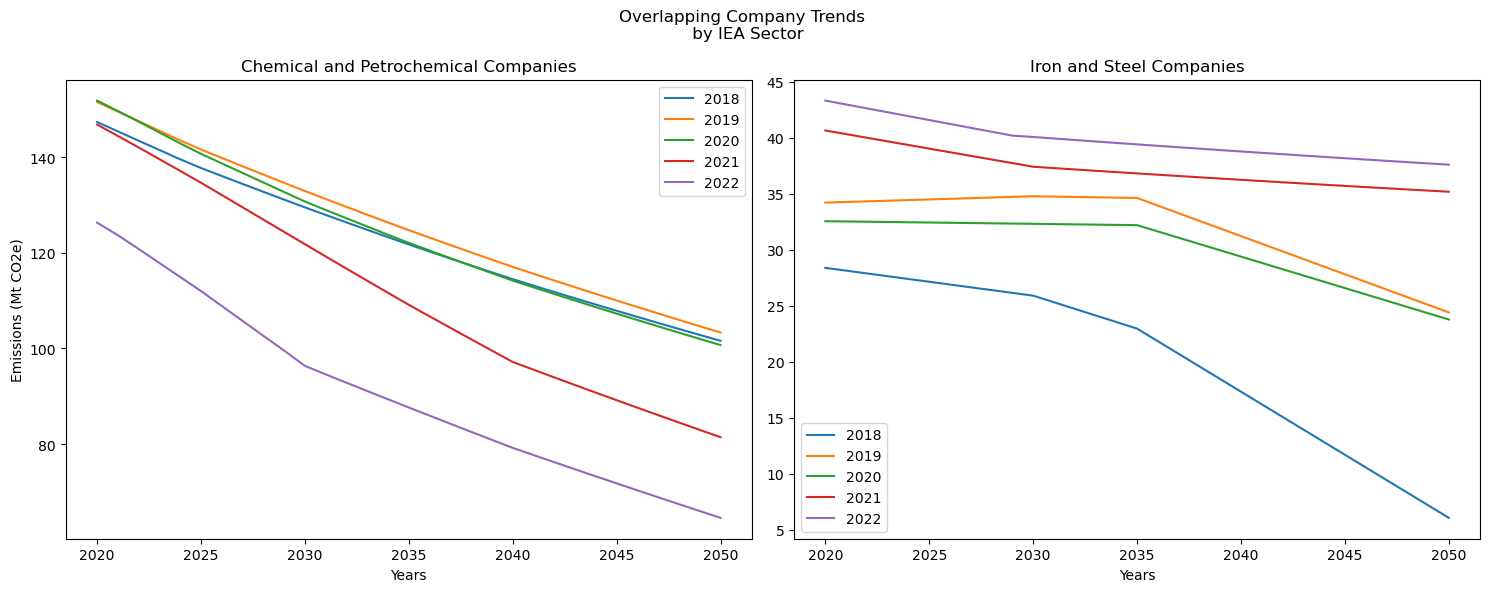

In [58]:
## VISUALISATION OF AMBITION PATHWAYS FOR OVERLAPPING COMPANIES DISAGGREGATED BY IEA SECTOR AND YEAR
fig1 = plt.figure(figsize=(15, 6))


# if 'Chemical and petrochemical' in y2[i].index:
ax1 = fig1.add_subplot(121)
# if 'Iron and steel' in y2[i].index:
ax2 = fig1.add_subplot(122)
# if 'Non-metallic minerals' in y2[i].index:
#         ax3 = fig1.add_subplot(133)


x = list(range(2020, 2051))
y2 = ovcompanies_sectoragg
z2 = allcompanies_sectoragg

for i in range(len(y2)):
    if 'Chemical and petrochemical' in y2[i].index:
        ax1.plot(x, y2[i].loc['Chemical and petrochemical',2020:2050], label=legend_years[i])
    if 'Iron and steel' in y2[i].index:
        ax2.plot(x, y2[i].loc['Iron and steel',2020:2050], label=legend_years[i])
    # if 'Non-metallic minerals' in y2[i].index:
    #     ax3.plot(x, y2[i].loc['Non-metallic minerals',2020:2050], label=legend_years[i])
    ## There are no overlapping non-metallic mineral companies to plot
    
ax1.legend()
ax1.title.set_text('Chemical and Petrochemical Companies')
ax1.set_ylabel('Emissions (Mt CO2e)')
ax1.set_xlabel('Years')
ax2.legend()
ax2.title.set_text('Iron and Steel Companies')
ax2.set_xlabel('Years')

# Mid point of left and right x-positions
# mid = (fig1.subplotpars.right + fig1.subplotpars.left)/2

fig1.suptitle('Overlapping Company Trends \n by IEA Sector')
fig1.tight_layout()



if mry_calc == 'mry_standard':
    plt.savefig(r''+dir_data+'/output/Figures/IEASectorDISAGG_OV_AmbitionPathways_MRYSTANDARD.png')
elif mry_calc == 'mry_interpolate':
    plt.savefig(r''+dir_data+'/output/Figures/IEASectorDISAGG_OV_AmbitionPathways_MRYInterpolation.png')
    plt.savefig(r''+dir_data+'/output/ForDesigner/IEASectors_Overlapping.eps', format='eps')
    
# if mry_calc == 'mry_standard':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/IEASectorDISAGG_OV_AmbitionPathways.png')
# elif mry_calc == 'mry_interpolate':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/IEASectorDISAGG_OV_AmbitionPathways_MRYInterpolation.png')

In [59]:
## Export Excel for designer

chem_ov_data = []
iron_ov_data = []
# nm_ov_data = []

for i in range(len(legend_years)):
    c_data = y2[i].loc['Chemical and petrochemical',2020:2050]
    i_data = y2[i].loc['Iron and steel',2020:2050]
    # nm_data = y2[i].loc['Non-metallic minerals',2020:2050]
    chem_ov_data.append(c_data)
    iron_ov_data.append(i_data)
    # nm_ov_data.append(nm_data)
    
chem_ov = pd.concat(chem_ov_data, axis=1)
iron_ov = pd.concat(iron_ov_data, axis=1)
# nm_ov = pd.concat(nm_ov_data, axis=1)

for i in [chem_ov, iron_ov]:
    i.columns = [legend_years]


In [60]:
with pd.ExcelWriter(r''+dir_data+'/output/ForDesigner/IEASectors_OverlappingCompanyTrends.xlsx') as writer:
    chem_ov.to_excel(writer, sheet_name='Chemical and petrochemical')
    iron_ov.to_excel(writer, sheet_name='Iron and steel')
    # nm_ov.to_excel(writer, sheet_name='Non-metallic minerals')

<h3> Disaggregated IEA sectors, All companies </h3>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


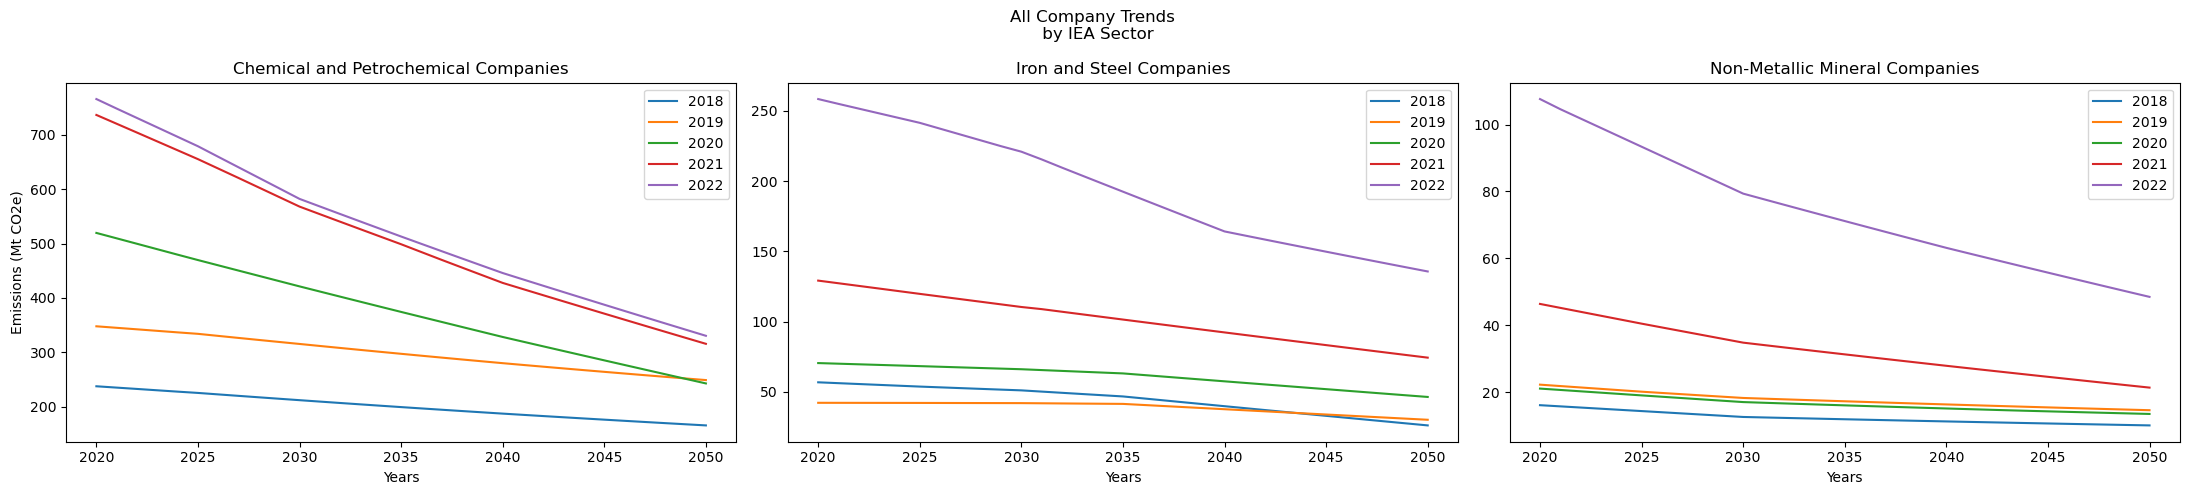

In [61]:
## VISUALISATION OF AMBITION PATHWAYS FOR ALL COMPANIES IN DISAGGREGATED BY IEA SECTOR AND YEAR
fig2 = plt.figure(figsize=(22, 5))
fig2.suptitle('All Company Trends \n by IEA Sector')


ax1 = fig2.add_subplot(131)
ax2 = fig2.add_subplot(132)
ax3 = fig2.add_subplot(133)

for i in range(len(z2)):
    if 'Chemical and petrochemical' in z2[i].index:
        ax1.plot(x, z2[i].loc['Chemical and petrochemical',2020:2050], label=legend_years[i])
    if 'Iron and steel' in z2[i].index:
        ax2.plot(x, z2[i].loc['Iron and steel',2020:2050], label=legend_years[i])
    if 'Non-metallic minerals' in z2[i].index:
        ax3.plot(x, z2[i].loc['Non-metallic minerals',2020:2050], label=legend_years[i])
    
ax1.legend()
ax1.title.set_text('Chemical and Petrochemical Companies')
ax1.set_ylabel('Emissions (Mt CO2e)')
ax1.set_xlabel('Years')
ax2.legend()
ax2.title.set_text('Iron and Steel Companies')
ax2.set_xlabel('Years')
ax3.legend()
ax3.title.set_text('Non-Metallic Mineral Companies')
ax3.set_xlabel('Years')
fig2.tight_layout()

if mry_calc == 'mry_standard':
    plt.savefig(r''+dir_data+'/output/Figures/IEASectorDISAGG_ALL_AmbitionPathways_MRYSTANDARD.png')
elif mry_calc == 'mry_interpolate':
    plt.savefig(r''+dir_data+'/output/Figures/IEASectorDISAGG_ALL_AmbitionPathways_MRYInterpolation.png')
    plt.savefig(r''+dir_data+'/output/ForDesigner/IEASectors_All.eps', format='eps')
    
# if mry_calc == 'mry_standard':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/IEASectorDISAGG_ALL_AmbitionPathways.png')
# elif mry_calc == 'mry_interpolate':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/IEASectorDISAGG_ALL_AmbitionPathways_MRYInterpolation.png')

In [62]:
## Export Excel for designer
chem_all_data = []
iron_all_data = []
nm_all_data = []

for i in range(len(legend_years)):
    c_data = z2[i].loc['Chemical and petrochemical',2020:2050]
    i_data = z2[i].loc['Iron and steel',2020:2050]
    nm_data = z2[i].loc['Non-metallic minerals',2020:2050]
    chem_all_data.append(c_data)
    iron_all_data.append(i_data)
    nm_all_data.append(nm_data)
    
chem_all = pd.concat(chem_all_data, axis=1)
iron_all = pd.concat(iron_all_data, axis=1)
nm_all = pd.concat(nm_all_data, axis=1)

for i in [chem_all, iron_all, nm_all]:
    i.columns = [legend_years]


In [63]:
with pd.ExcelWriter(r''+dir_data+'/output/ForDesigner/IEASectors_AllCompanyTrends.xlsx') as writer:
    chem_all.to_excel(writer, sheet_name='Chemical and petrochemical')
    iron_all.to_excel(writer, sheet_name='Iron and steel')
    nm_all.to_excel(writer, sheet_name='Non-metallic minerals')

<h2> Min/Median/Max Tables </h2>

In [64]:
## Gather min/median/max stats for by emissions, mry emissions, and targeted reductions for each year
by_stats = []
mry_stats = []
target_stats = []

for i in final_selections:
    by = i['by_em_final'].describe()
    by_stats.append(by[[3,5,7]])
    mry = i['mry_em_final'].describe()
    mry_stats.append(mry[[3,5,7]])
    t = i[['targeted_reduction_1', 'targeted_reduction_2', 'targeted_reduction_3', 'targeted_reduction_4', 'targeted_reduction_5']].describe()
    target_stats.append(t.iloc[[3,5,7],:])
    

In [65]:
## Create dataframe to combine min/median/max values for each metric together
iterables = [years, ['min', '50%', 'max']]

index = pd.MultiIndex.from_product(iterables, names=['Year', 'Metrics'])

em_stats = pd.DataFrame(index=index, columns=['BY_em', 'MRY_em'])

em_stats['BY_em'] = list(np.concatenate(by_stats).flat)

em_stats['MRY_em'] = list(np.concatenate(mry_stats).flat)

In [66]:
targetstats_merged = pd.concat(target_stats, keys=years)

In [67]:
mmm_table = pd.concat([em_stats, targetstats_merged], axis=1)

In [68]:
## Export min/median/max for ALL companies by reporting year
if mry_calc == 'mry_standard':
    mmm_table.to_excel(r''+dir_data+'/output/Final/MinMedMax_ALL_MRYStandard.xlsx')
elif mry_calc == 'mry_interpolate':
    mmm_table.to_excel(r''+dir_data+'/output/Final/MinMedMax_ALL_MRYInterpolate.xlsx')
    
# if mry_calc == 'mry_standard':
#     mmm_table.to_excel(r''+dir_data+'/output/OLD/Final/MinMedMax_ALL_MRYStandard.xlsx')
# elif mry_calc == 'mry_interpolate':
#     mmm_table.to_excel(r''+dir_data+'/output/OLD/Final/MinMedMax_ALL_MRYInterpolate.xlsx')

<h2> Distribution Graphing: BY EM, MRY EM & Targeted Reductions </h2>

<h3> Distribution BY emissions </h3>

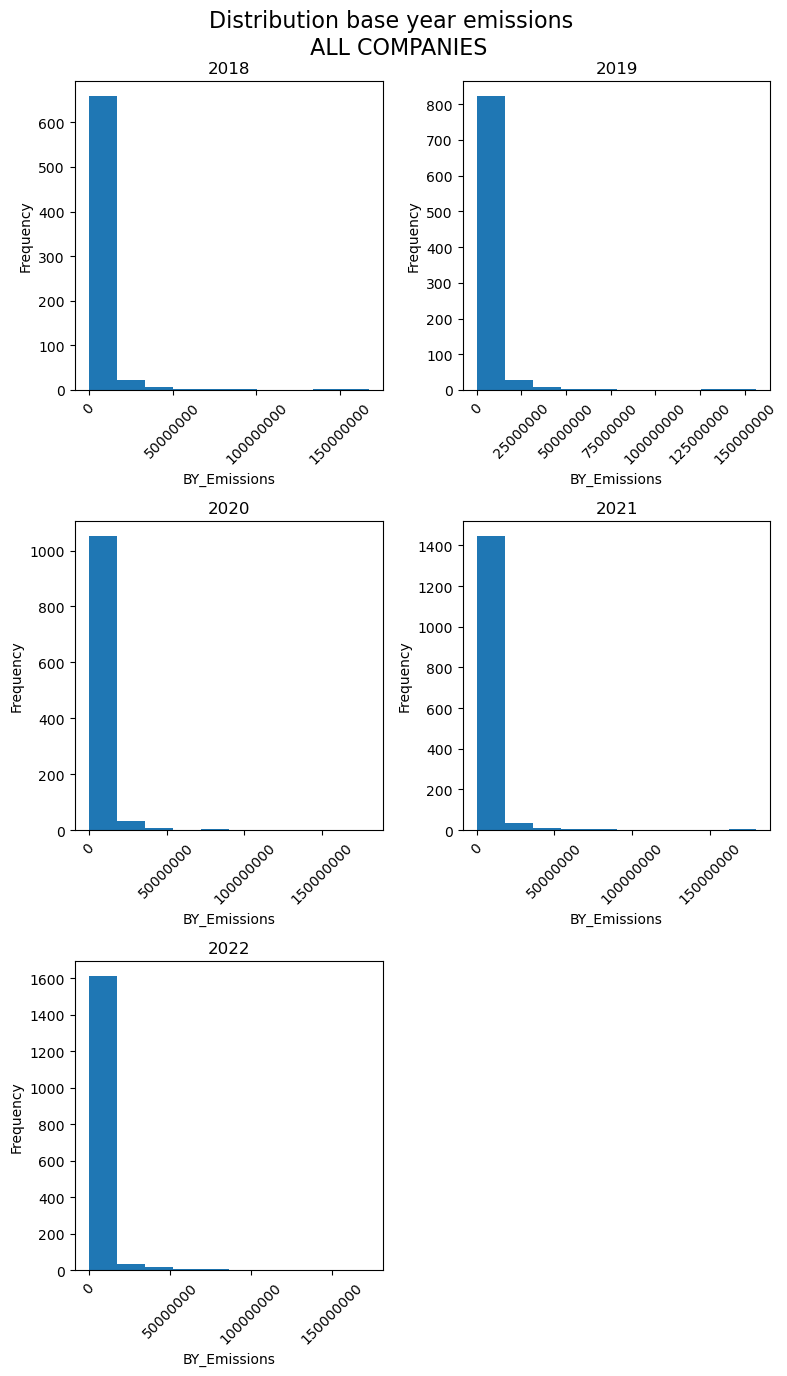

In [69]:
import seaborn as sns

fig3 = plt.figure(figsize=(8,14))

ax1 = fig3.add_subplot(321)
ax2 = fig3.add_subplot(322)
ax3 = fig3.add_subplot(323)
ax4 = fig3.add_subplot(324)
ax5 = fig3.add_subplot(325)


ax1.hist(x=final_selections[0]['by_em_final'])
ax1.set_title('2018')
ax2.hist(x=final_selections[1]['by_em_final'])
ax2.set_title('2019')
ax3.hist(x=final_selections[2]['by_em_final'])
ax3.set_title('2020')
ax4.hist(x=final_selections[3]['by_em_final'])
ax4.set_title('2021')
ax5.hist(x=final_selections[4]['by_em_final'])
ax5.set_title('2022')

for i in [ax1, ax2, ax3, ax4, ax5]:
    i.set_xlabel('BY_Emissions')
    i.set_ylabel('Frequency')
    i.ticklabel_format(style='plain', axis='x')
    i.tick_params(axis='x', labelrotation=45)

fig3.suptitle('Distribution base year emissions \n ALL COMPANIES', fontsize=16)

fig3.tight_layout()

if mry_calc == 'mry_standard':
    plt.savefig(r''+dir_data+'/output/Figures/BYEmissions/BYEM_ALL_Historgram_MRYStandard.png')
elif mry_calc == 'mry_interpolate':
    plt.savefig(r''+dir_data+'/output/Figures/BYEmissions/BYEM_ALL_Historgram_MRYInterpolation.png')
    
# if mry_calc == 'mry_standard':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/BYEM_ALL_Historgram_MRYStandard.png')
# elif mry_calc == 'mry_interpolate':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/BYEM_ALL_Historgram_MRYInterpolation.png')

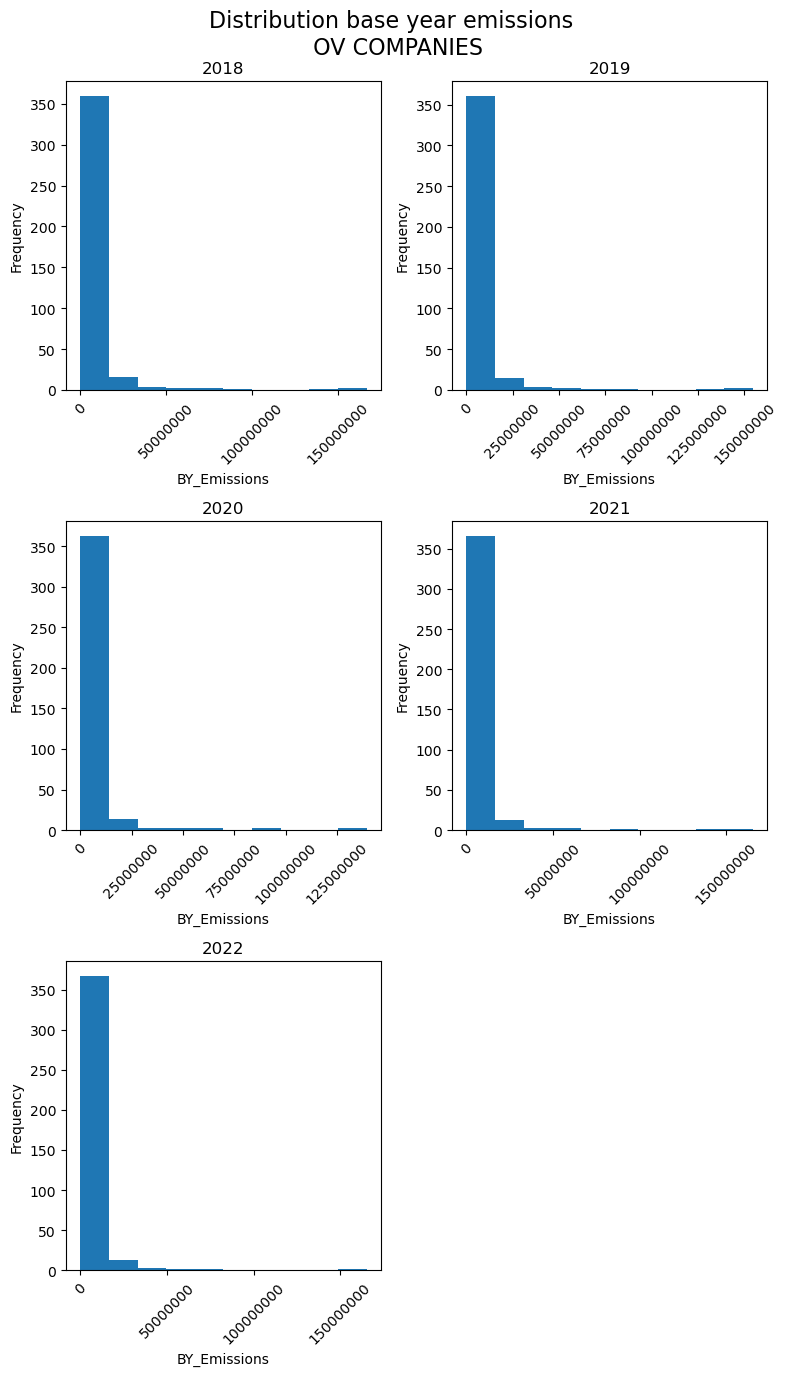

In [70]:
fig4 = plt.figure(figsize=(8,14))

ax1 = fig4.add_subplot(321)
ax2 = fig4.add_subplot(322)
ax3 = fig4.add_subplot(323)
ax4 = fig4.add_subplot(324)
ax5 = fig4.add_subplot(325)


ax1.hist(x=overlapping_series[0]['by_em_final'])
ax1.set_title('2018')
ax2.hist(x=overlapping_series[1]['by_em_final'])
ax2.set_title('2019')
ax3.hist(x=overlapping_series[2]['by_em_final'])
ax3.set_title('2020')
ax4.hist(x=overlapping_series[3]['by_em_final'])
ax4.set_title('2021')
ax5.hist(x=overlapping_series[4]['by_em_final'])
ax5.set_title('2022')

for i in [ax1, ax2, ax3, ax4, ax5]:
    i.set_xlabel('BY_Emissions')
    i.set_ylabel('Frequency')
    i.ticklabel_format(style='plain', axis='x')
    i.tick_params(axis='x', labelrotation=45)

fig4.suptitle('Distribution base year emissions \n OV COMPANIES', fontsize=16)

fig4.tight_layout()

if mry_calc == 'mry_standard':
    plt.savefig(r''+dir_data+'/output/Figures/BYEmissions/BYEM_OV_Historgram_MRYStandard.png')
elif mry_calc == 'mry_interpolate':
    plt.savefig(r''+dir_data+'/output/Figures/BYEmissions/BYEM_OV_Historgram_MRYInterpolation.png')
    
# if mry_calc == 'mry_standard':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/BYEM_OV_Historgram_MRYStandard.png')
# elif mry_calc == 'mry_interpolate':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/BYEM_OV_Historgram_MRYInterpolation.png')

<h3> Distribution Annual Reductions (NOT USED IN REPORT) </h3>

In [71]:
for i in final_selections:
    i['annual_reduction'] = abs((i['ty1_em_final'] - i['by_em_final'])/(i['target_year_1'] - i['base_year']))

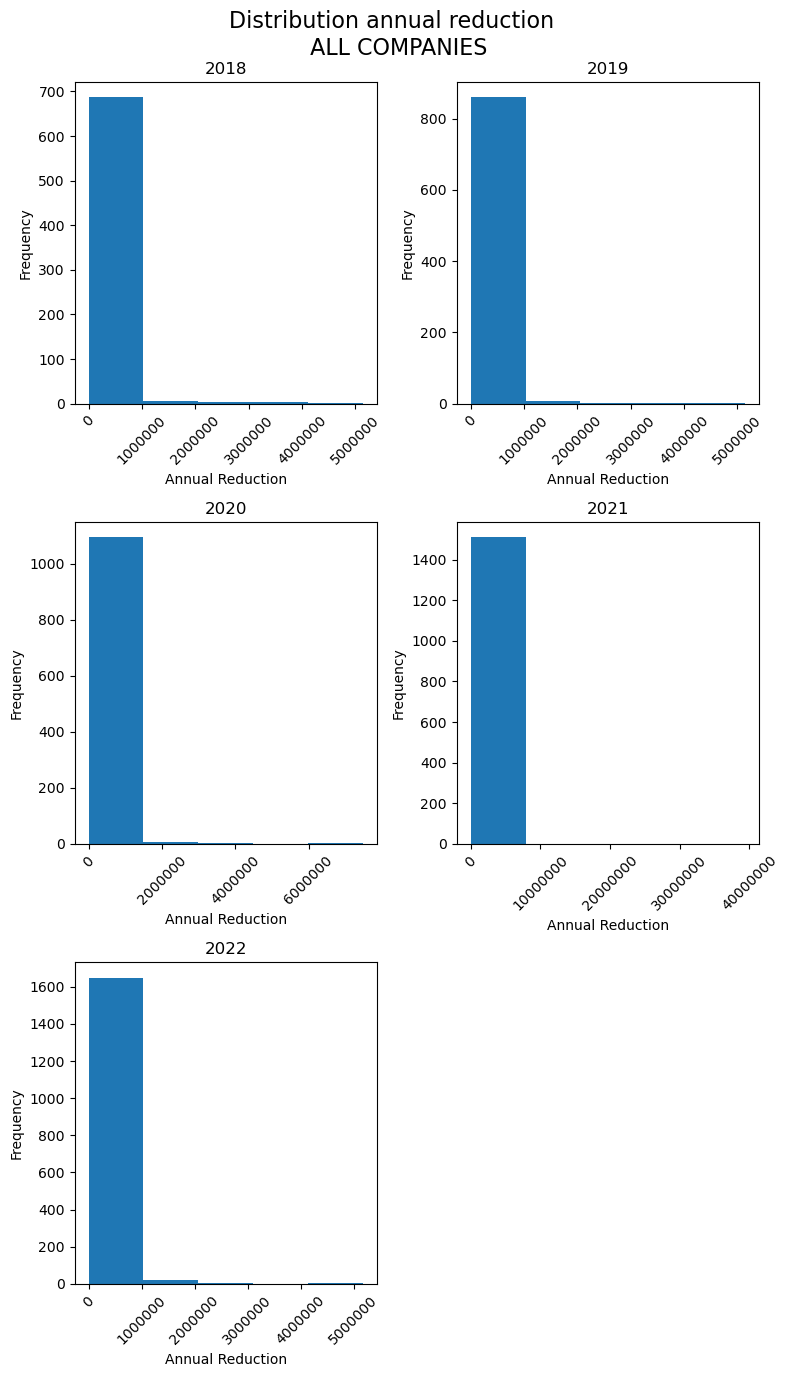

In [72]:
## Graph ANNUAL REDUCTION from base year to target year over datasets
## To answer: Is the annual reduction increasing in later reporting years?

fig13 = plt.figure(figsize=(8,14))

ax1 = fig13.add_subplot(321)
ax2 = fig13.add_subplot(322)
ax3 = fig13.add_subplot(323)
ax4 = fig13.add_subplot(324)
ax5 = fig13.add_subplot(325)

n_bins = 5
# n_range = (0, 4000000)

ax1.hist(x=final_selections[0]['annual_reduction'],  bins=n_bins)
ax1.set_title('2018')
ax2.hist(x=final_selections[1]['annual_reduction'],  bins=n_bins)
ax2.set_title('2019')
ax3.hist(x=final_selections[2]['annual_reduction'],  bins=n_bins)
ax3.set_title('2020')
ax4.hist(x=final_selections[3]['annual_reduction'],  bins=n_bins)
ax4.set_title('2021')
ax5.hist(x=final_selections[4]['annual_reduction'],  bins=n_bins)
ax5.set_title('2022')

for i in [ax1, ax2, ax3, ax4, ax5]:
    i.set_xlabel('Annual Reduction')
    i.set_ylabel('Frequency')
    i.ticklabel_format(style='plain', axis='x')
    i.tick_params(axis='x', labelrotation=45)

fig13.suptitle('Distribution annual reduction \n ALL COMPANIES', fontsize=16)

fig13.tight_layout()

if mry_calc == 'mry_standard':
    plt.savefig(r''+dir_data+'/output/Figures/BYEmissions/AnnualReduction_ALL_Histogram_MRYStandard.png')
elif mry_calc == 'mry_interpolate':
    plt.savefig(r''+dir_data+'/output/Figures/BYEmissions/AnnualReduction_ALL_Histogram_MRYInterpolation.png')

In [73]:
for i in overlapping_series:
    i['annual_reduction'] = (i['by_em_final'] - i['ty1_em_final'])/(i['target_year_1'] - i['base_year'])

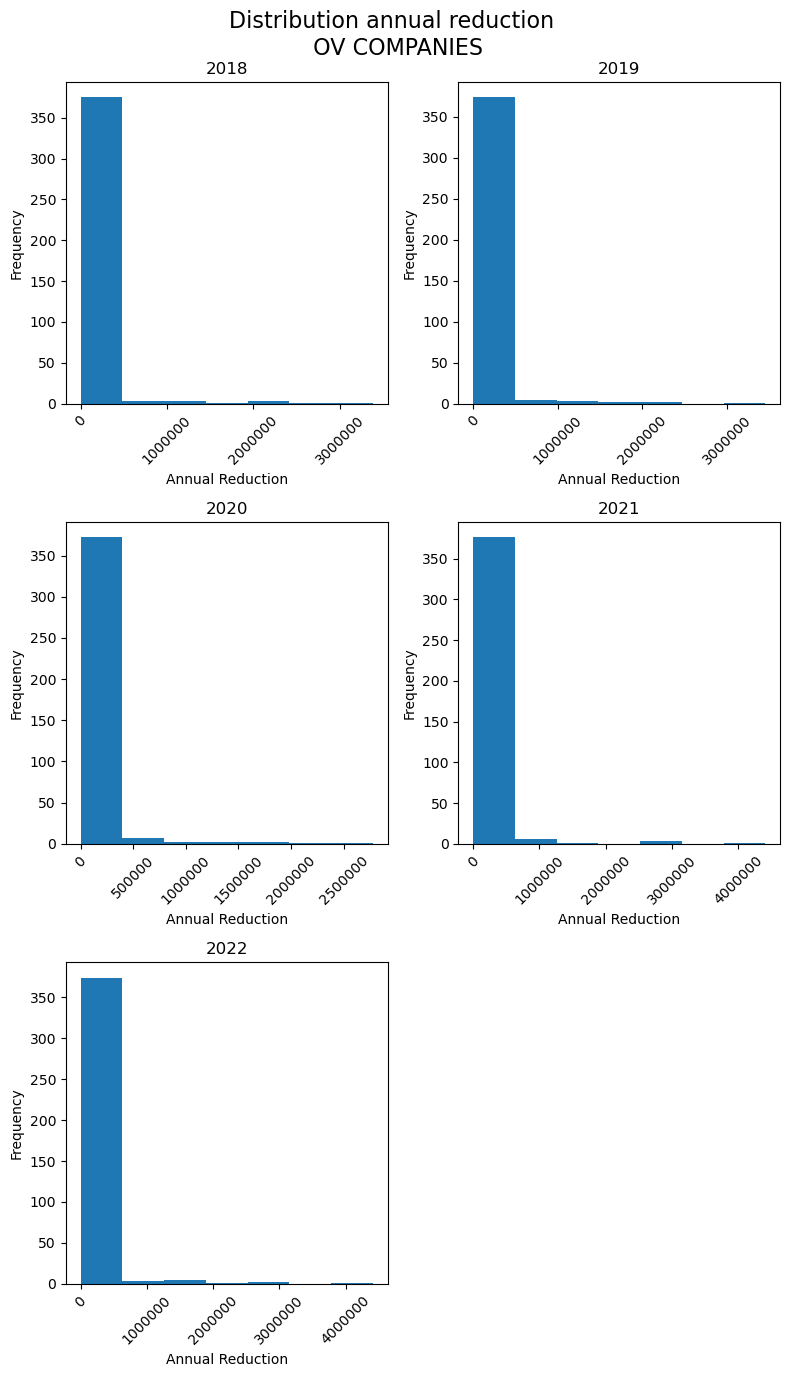

In [74]:
fig14 = plt.figure(figsize=(8,14))

ax1 = fig14.add_subplot(321)
ax2 = fig14.add_subplot(322)
ax3 = fig14.add_subplot(323)
ax4 = fig14.add_subplot(324)
ax5 = fig14.add_subplot(325)

n_bins = 7
# n_range = (0, 4000000)

ax1.hist(x=overlapping_series[0]['annual_reduction'],  bins=n_bins)
ax1.set_title('2018')
ax2.hist(x=overlapping_series[1]['annual_reduction'],  bins=n_bins)
ax2.set_title('2019')
ax3.hist(x=overlapping_series[2]['annual_reduction'],  bins=n_bins)
ax3.set_title('2020')
ax4.hist(x=overlapping_series[3]['annual_reduction'],  bins=n_bins)
ax4.set_title('2021')
ax5.hist(x=overlapping_series[4]['annual_reduction'],  bins=n_bins)
ax5.set_title('2022')

for i in [ax1, ax2, ax3, ax4, ax5]:
    i.set_xlabel('Annual Reduction')
    i.set_ylabel('Frequency')
    i.ticklabel_format(style='plain', axis='x')
    i.tick_params(axis='x', labelrotation=45)

fig14.suptitle('Distribution annual reduction \n OV COMPANIES', fontsize=16)

fig14.tight_layout()

if mry_calc == 'mry_standard':
    plt.savefig(r''+dir_data+'/output/Figures/BYEmissions/AnnualReduction_OV_Histogram_MRYStandard.png')
elif mry_calc == 'mry_interpolate':
    plt.savefig(r''+dir_data+'/output/Figures/BYEmissions/AnnualReduction_OV_Histogram_MRYInterpolation.png')

<h3> Distribution MRY emissions </h3>

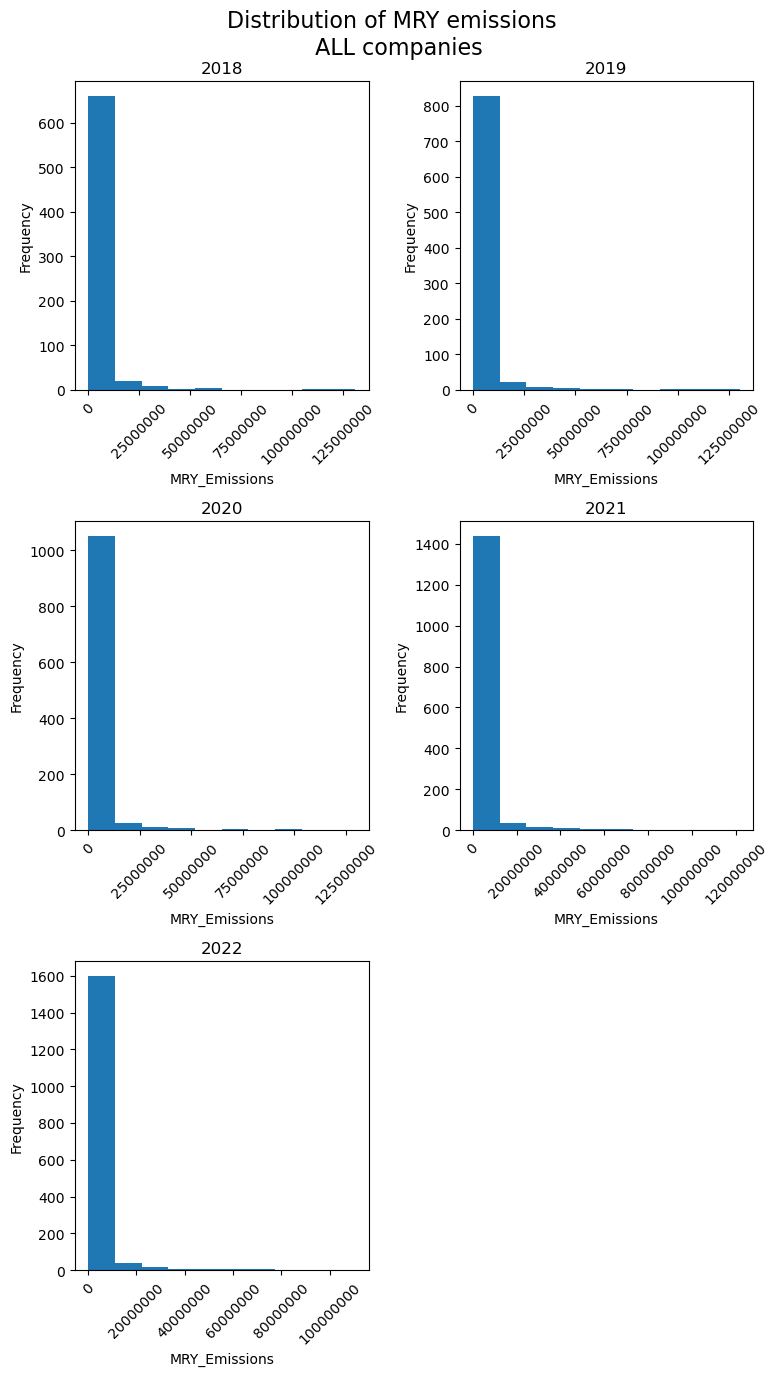

In [75]:
fig5 = plt.figure(figsize=(8,14))

ax1 = fig5.add_subplot(321)
ax2 = fig5.add_subplot(322)
ax3 = fig5.add_subplot(323)
ax4 = fig5.add_subplot(324)
ax5 = fig5.add_subplot(325)


ax1.hist(x=final_selections[0]['mry_em_final'])
ax1.set_title('2018')
ax2.hist(x=final_selections[1]['mry_em_final'])
ax2.set_title('2019')
ax3.hist(x=final_selections[2]['mry_em_final'])
ax3.set_title('2020')
ax4.hist(x=final_selections[3]['mry_em_final'])
ax4.set_title('2021')
ax5.hist(x=final_selections[4]['mry_em_final'])
ax5.set_title('2022')

for i in [ax1, ax2, ax3, ax4, ax5]:
    i.set_xlabel('MRY_Emissions')
    i.set_ylabel('Frequency')
    i.ticklabel_format(style='plain', axis='x')
    i.tick_params(axis='x', labelrotation=45)
    # i.set_xticks(np.arange(min(final_selections[i]['mry_em_final']), max(final_selections[i]['mry_em_final']), 5000000))



fig5.suptitle('Distribution of MRY emissions \n ALL companies', fontsize=16)

fig5.tight_layout()

if mry_calc == 'mry_standard':
    plt.savefig(r''+dir_data+'/output/Figures/MRYEmissions/MRYEM_ALL_Historgram_MRYStandard.png')
elif mry_calc == 'mry_interpolate':
    plt.savefig(r''+dir_data+'/output/Figures/MRYEmissions/MRYEM_ALL_Historgram_MRYInterpolation.png')
    
# if mry_calc == 'mry_standard':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/MRYEM_ALL_Historgram_MRYStandard.png')
# elif mry_calc == 'mry_interpolate':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/MRYEM_ALL_Historgram_MRYInterpolation.png')

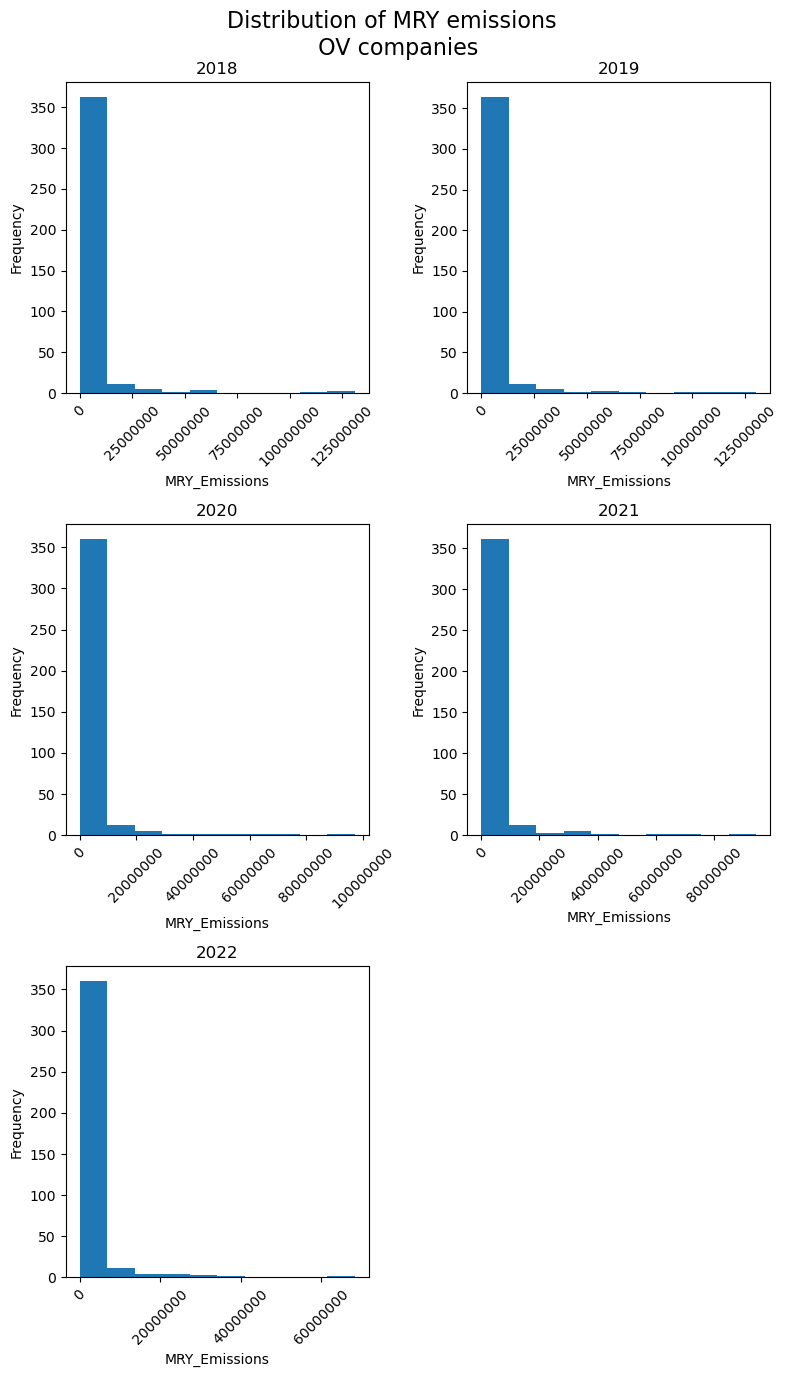

In [76]:
fig6 = plt.figure(figsize=(8,14))

ax1 = fig6.add_subplot(321)
ax2 = fig6.add_subplot(322)
ax3 = fig6.add_subplot(323)
ax4 = fig6.add_subplot(324)
ax5 = fig6.add_subplot(325)


ax1.hist(x=overlapping_series[0]['mry_em_final'])
ax1.set_title('2018')
ax2.hist(x=overlapping_series[1]['mry_em_final'])
ax2.set_title('2019')
ax3.hist(x=overlapping_series[2]['mry_em_final'])
ax3.set_title('2020')
ax4.hist(x=overlapping_series[3]['mry_em_final'])
ax4.set_title('2021')
ax5.hist(x=overlapping_series[4]['mry_em_final'])
ax5.set_title('2022')

for i in [ax1, ax2, ax3, ax4, ax5]:
    i.set_xlabel('MRY_Emissions')
    i.set_ylabel('Frequency')
    i.ticklabel_format(style='plain', axis='x')
    i.tick_params(axis='x', labelrotation=45)
    # i.set_xticks(np.arange(min(final_selections[i]['mry_em_final']), max(final_selections[i]['mry_em_final']), 5000000))



fig6.suptitle('Distribution of MRY emissions \n OV companies', fontsize=16)

fig6.tight_layout()

if mry_calc == 'mry_standard':
    plt.savefig(r''+dir_data+'/output/Figures/MRYEmissions/MRYEM_OV_Historgram_MRYStandard.png')
elif mry_calc == 'mry_interpolate':
    plt.savefig(r''+dir_data+'/output/Figures/MRYEmissions/MRYEM_OV_Historgram_MRYInterpolation.png')
    
# if mry_calc == 'mry_standard':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/MRYEM_OV_Historgram_MRYStandard.png')
# elif mry_calc == 'mry_interpolate':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/MRYEM_OV_Historgram_MRYInterpolation.png')

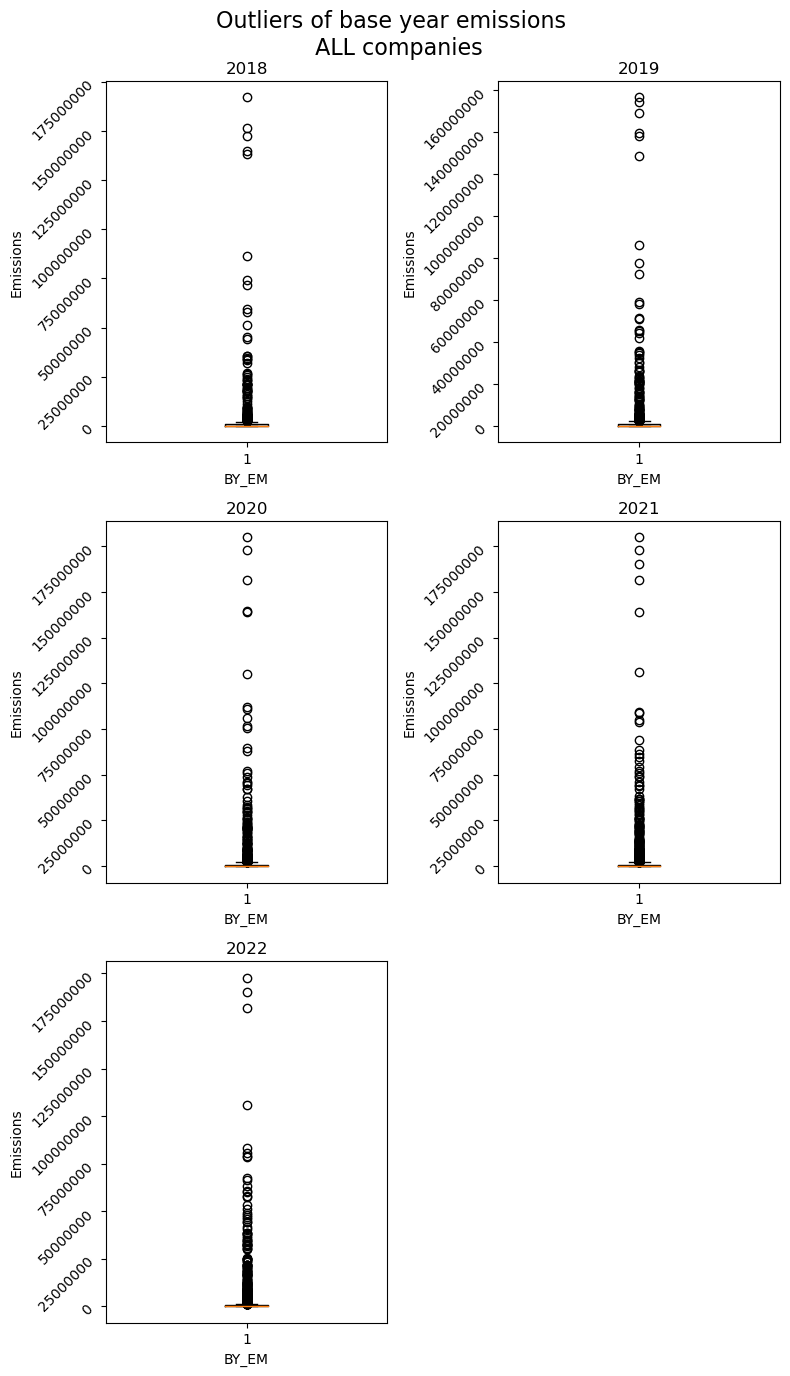

In [77]:
fig7 = plt.figure(figsize=(8,14))

ax1 = fig7.add_subplot(321)
ax2 = fig7.add_subplot(322)
ax3 = fig7.add_subplot(323)
ax4 = fig7.add_subplot(324)
ax5 = fig7.add_subplot(325)


ax1.boxplot(x=final_selections[0]['by_em_final'])
ax1.set_title('2018')
ax2.boxplot(x=final_selections[1]['by_em_final'])
ax2.set_title('2019')
ax3.boxplot(x=final_selections[2]['by_em_final'])
ax3.set_title('2020')
ax4.boxplot(x=final_selections[3]['by_em_final'])
ax4.set_title('2021')
ax5.boxplot(x=final_selections[4]['by_em_final'])
ax5.set_title('2022')

for i in [ax1, ax2, ax3, ax4, ax5]:
    i.set_xlabel('BY_EM')
    i.set_ylabel('Emissions')
    i.ticklabel_format(style='plain', axis='y')
    i.tick_params(axis='y', labelrotation=45)

fig7.suptitle('Outliers of base year emissions \n ALL companies', fontsize=16)

fig7.tight_layout()

if mry_calc == 'mry_standard':
    plt.savefig(r''+dir_data+'/output/Figures/BYEmissions/BYEM_ALL_Boxplot_MRYStandard.png')
elif mry_calc == 'mry_interpolate':
    plt.savefig(r''+dir_data+'/output/Figures/BYEmissions/BYEM_ALL_Boxplot_MRYInterpolation.png')
    
# if mry_calc == 'mry_standard':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/BYEM_ALL_Boxplot_MRYStandard.png')
# elif mry_calc == 'mry_interpolate':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/BYEM_ALL_Boxplot_MRYInterpolation.png')

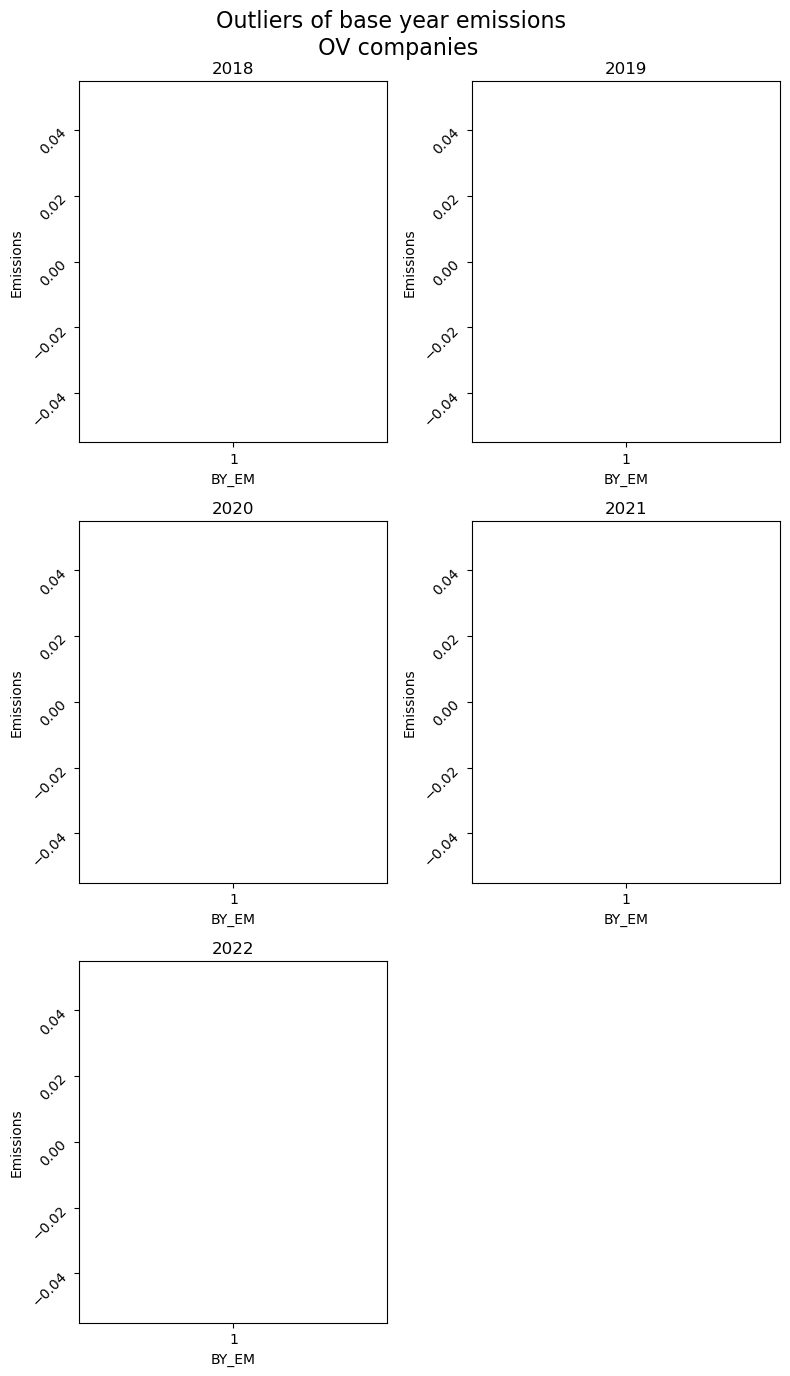

In [78]:
fig8 = plt.figure(figsize=(8,14))

ax1 = fig8.add_subplot(321)
ax2 = fig8.add_subplot(322)
ax3 = fig8.add_subplot(323)
ax4 = fig8.add_subplot(324)
ax5 = fig8.add_subplot(325)


ax1.boxplot(x=overlapping_series[0]['by_em_final'])
ax1.set_title('2018')
ax2.boxplot(x=overlapping_series[1]['by_em_final'])
ax2.set_title('2019')
ax3.boxplot(x=overlapping_series[2]['by_em_final'])
ax3.set_title('2020')
ax4.boxplot(x=overlapping_series[3]['by_em_final'])
ax4.set_title('2021')
ax5.boxplot(x=overlapping_series[4]['by_em_final'])
ax5.set_title('2022')

for i in [ax1, ax2, ax3, ax4, ax5]:
    i.set_xlabel('BY_EM')
    i.set_ylabel('Emissions')
    i.ticklabel_format(style='plain', axis='y')
    i.tick_params(axis='y', labelrotation=45)

fig8.suptitle('Outliers of base year emissions \n OV companies', fontsize=16)

fig8.tight_layout()

if mry_calc == 'mry_standard':
    plt.savefig(r''+dir_data+'/output/Figures/BYEmissions/BYEM_OV_Boxplot_MRYStandard.png')
elif mry_calc == 'mry_interpolate':
    plt.savefig(r''+dir_data+'/output/Figures/BYEmissions/BYEM_OV_Boxplot_MRYInterpolation.png')
    
# if mry_calc == 'mry_standard':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/BYEM_OV_Boxplot_MRYStandard.png')
# elif mry_calc == 'mry_interpolate':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/BYEM_OV_Boxplot_MRYInterpolation.png')

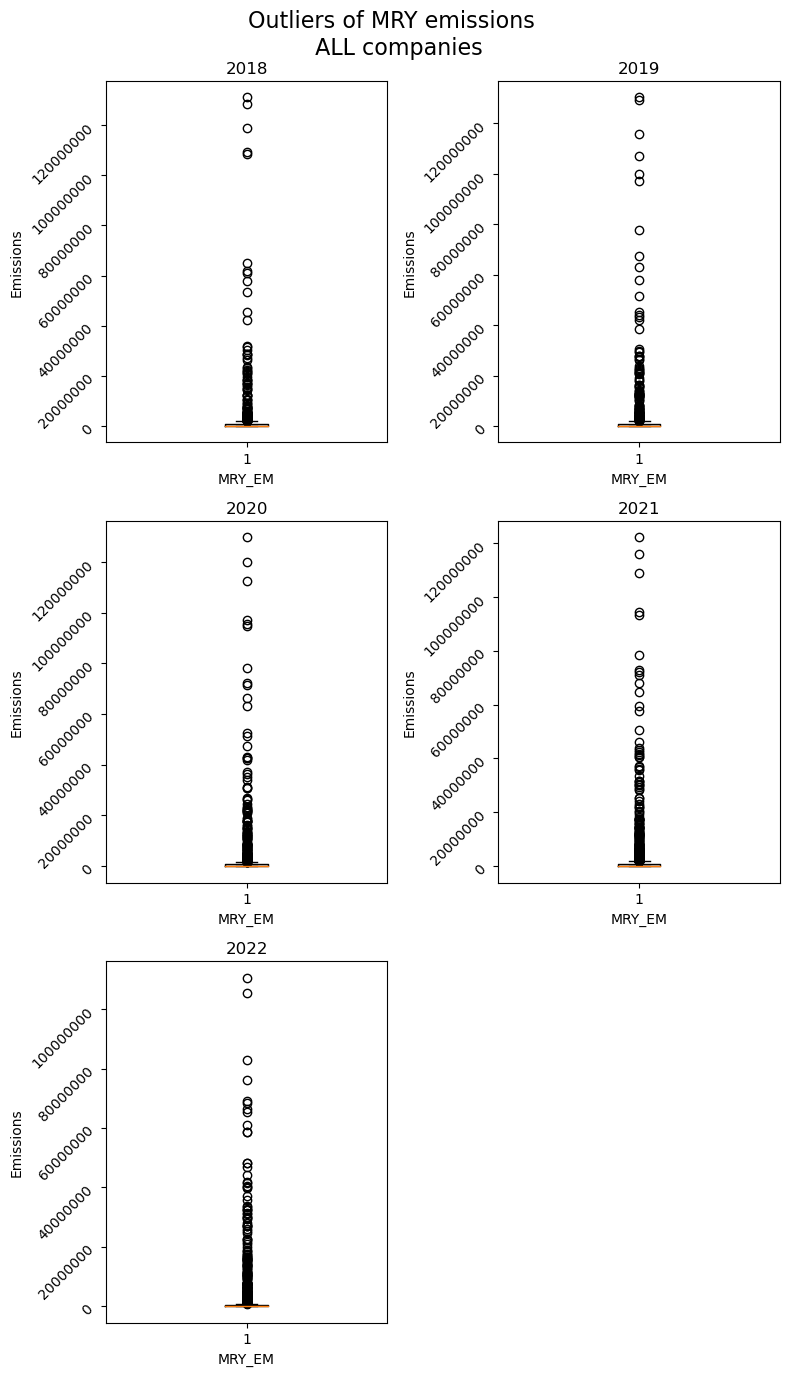

In [79]:
fig9 = plt.figure(figsize=(8,14))

ax1 = fig9.add_subplot(321)
ax2 = fig9.add_subplot(322)
ax3 = fig9.add_subplot(323)
ax4 = fig9.add_subplot(324)
ax5 = fig9.add_subplot(325)


ax1.boxplot(x=final_selections[0]['mry_em_final'])
ax1.set_title('2018')
ax2.boxplot(x=final_selections[1]['mry_em_final'])
ax2.set_title('2019')
ax3.boxplot(x=final_selections[2]['mry_em_final'])
ax3.set_title('2020')
ax4.boxplot(x=final_selections[3]['mry_em_final'])
ax4.set_title('2021')
ax5.boxplot(x=final_selections[4]['mry_em_final'])
ax5.set_title('2022')

for i in [ax1, ax2, ax3, ax4, ax5]:
    i.set_xlabel('MRY_EM')
    i.set_ylabel('Emissions')
    i.ticklabel_format(style='plain', axis='y')
    i.tick_params(axis='y', labelrotation=45)

fig9.suptitle('Outliers of MRY emissions \n ALL companies', fontsize=16)

fig9.tight_layout()

if mry_calc == 'mry_standard':
    plt.savefig(r''+dir_data+'/output/Figures/MRYEmissions/MRYEM_ALL_Boxplot_MRYStandard.png')
elif mry_calc == 'mry_interpolate':
    plt.savefig(r''+dir_data+'/output/Figures/MRYEmissions/MRYEM_ALL_Boxplot_MRYInterpolation.png')
    
# if mry_calc == 'mry_standard':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/MRYEM_ALL_Boxplot_MRYStandard.png')
# elif mry_calc == 'mry_interpolate':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/MRYEM_ALL_Boxplot_MRYInterpolation.png')

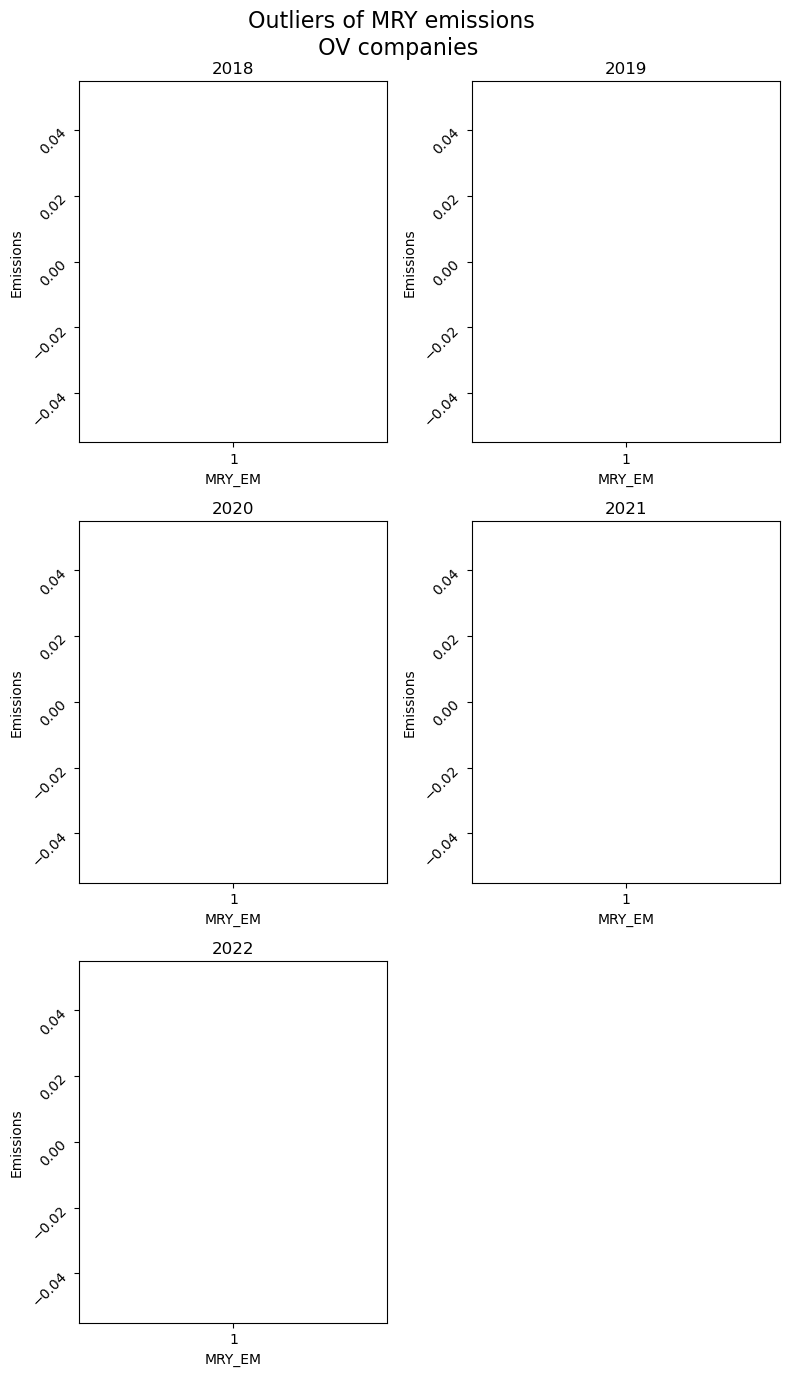

In [80]:
fig10 = plt.figure(figsize=(8,14))

ax1 = fig10.add_subplot(321)
ax2 = fig10.add_subplot(322)
ax3 = fig10.add_subplot(323)
ax4 = fig10.add_subplot(324)
ax5 = fig10.add_subplot(325)


ax1.boxplot(x=overlapping_series[0]['mry_em_final'])
ax1.set_title('2018')
ax2.boxplot(x=overlapping_series[1]['mry_em_final'])
ax2.set_title('2019')
ax3.boxplot(x=overlapping_series[2]['mry_em_final'])
ax3.set_title('2020')
ax4.boxplot(x=overlapping_series[3]['mry_em_final'])
ax4.set_title('2021')
ax5.boxplot(x=overlapping_series[4]['mry_em_final'])
ax5.set_title('2022')

for i in [ax1, ax2, ax3, ax4, ax5]:
    i.set_xlabel('MRY_EM')
    i.set_ylabel('Emissions')
    i.ticklabel_format(style='plain', axis='y')
    i.tick_params(axis='y', labelrotation=45)

fig10.suptitle('Outliers of MRY emissions \n OV companies', fontsize=16)

fig10.tight_layout()

if mry_calc == 'mry_standard':
    plt.savefig(r''+dir_data+'/output/Figures/MRYEmissions/MRYEM_OV_Boxplot_MRYStandard.png')
elif mry_calc == 'mry_interpolate':
    plt.savefig(r''+dir_data+'/output/Figures/MRYEmissions/MRYEM_OV_Boxplot_MRYInterpolation.png')
    
# if mry_calc == 'mry_standard':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/MRYEM_OV_Boxplot_MRYStandard.png')
# elif mry_calc == 'mry_interpolate':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/MRYEM_OV_Boxplot_MRYInterpolation.png')

<h3> Distribution of targeted reductions </h3>

In [81]:
targets = ['targeted_reduction_1','targeted_reduction_2','targeted_reduction_3','targeted_reduction_4','targeted_reduction_5']

to_concat = []

hist_list = []

for i in final_selections:
    for t in targets:
        item = i[t]
        to_concat.append(item)
    concat_items = pd.concat(to_concat, axis=0).dropna()
    hist_list.append(concat_items)

In [82]:
avg_list = []

for i in range(len(hist_list)):
    avg = hist_list[i].mean()
    avg_list.append(avg)

avg_reductions = pd.DataFrame(data=avg_list, index=years, columns=['Average Targeted Reduction'])
    
# avg_reductions

<h4> Distribution targeted reductions - All companies </h4>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


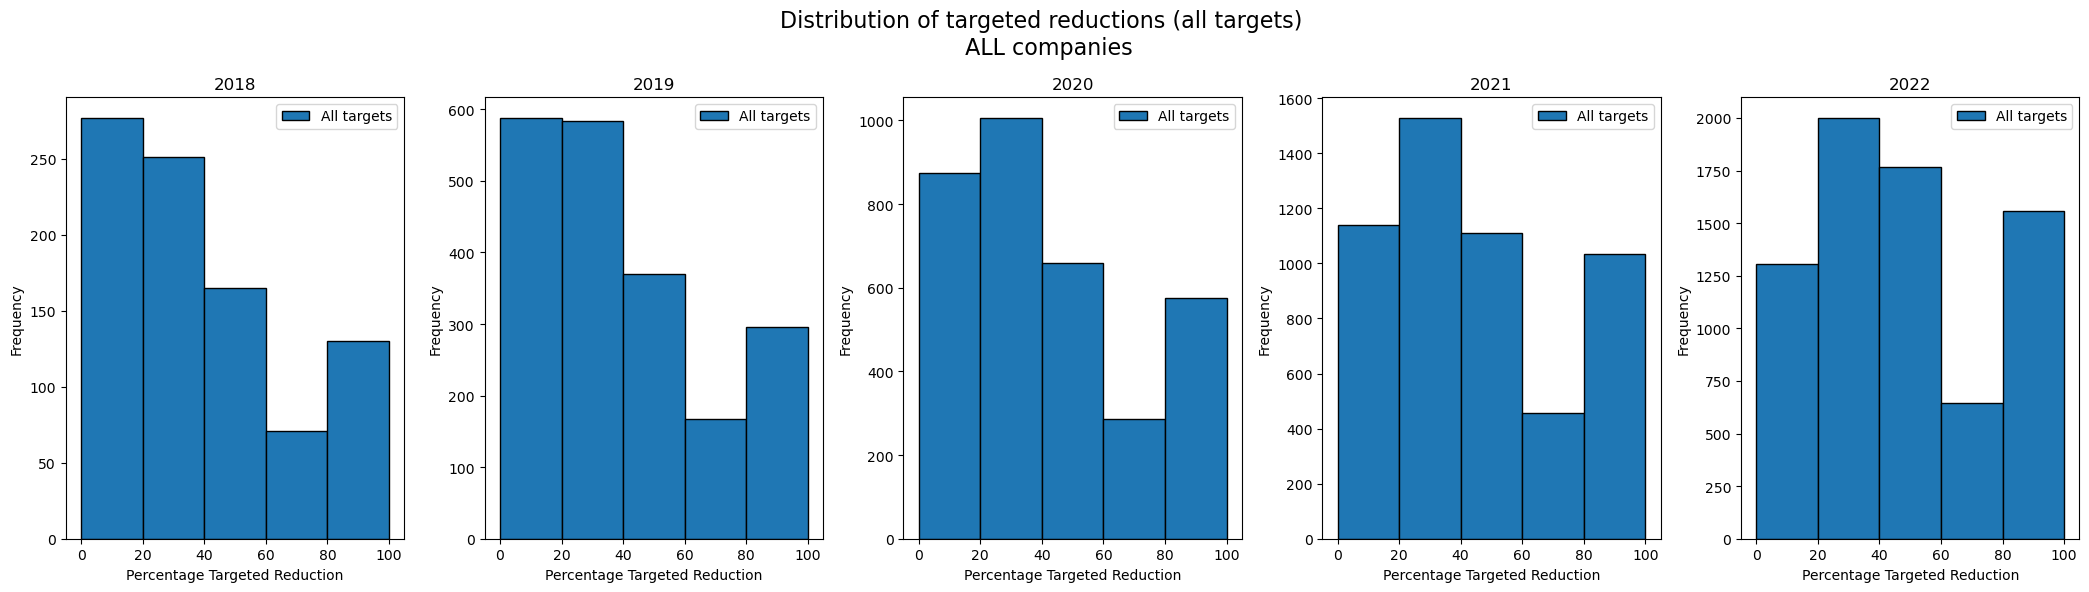

In [83]:
fig11 = plt.figure(figsize=(21,6))    

ax1 = fig11.add_subplot(151)
ax2 = fig11.add_subplot(152)
ax3 = fig11.add_subplot(153)
ax4 = fig11.add_subplot(154)
ax5 = fig11.add_subplot(155)

n_bins = 5
edge = 'black'

## Plotting all targets together, showing total frequencies
ax1.hist(x=hist_list[0], bins=n_bins, edgecolor=edge)
ax1.set_title('2018')
ax2.hist(x=hist_list[1], bins=n_bins, edgecolor=edge)
ax2.set_title('2019')
ax3.hist(x=hist_list[2], bins=n_bins, edgecolor=edge)
ax3.set_title('2020')
ax4.hist(x=hist_list[3], bins=n_bins, edgecolor=edge)
ax4.set_title('2021')
ax5.hist(x=hist_list[4], bins=n_bins, edgecolor=edge)
ax5.set_title('2022')

## Plotting stacked version showing color coded frequencies of each target types (targeted_reduction_1, targeted_reduction_2, etc.)
# ax1.hist(x=final_selections[0][targets], stacked=True, bins=n_bins)
# ax1.set_title('2018')
# ax2.hist(x=final_selections[1][targets], stacked=True, bins=n_bins)
# ax2.set_title('2019')
# ax3.hist(x=final_selections[2][targets], stacked=True, bins=n_bins)
# ax3.set_title('2020')
# ax4.hist(x=final_selections[3][targets], stacked=True, bins=n_bins)
# ax4.set_title('2021')
# ax5.hist(x=final_selections[4][targets], stacked=True, bins=n_bins)
# ax5.set_title('2022')

for i in [ax1, ax2, ax3, ax4, ax5]:
    i.set_xlabel('Percentage Targeted Reduction')
    i.set_ylabel('Frequency')
    i.legend(labels=['All targets'])
    
fig11.suptitle('Distribution of targeted reductions (all targets) \n ALL companies', fontsize=16)

fig11.tight_layout()

if mry_calc == 'mry_standard':
    plt.savefig(r''+dir_data+'/output/Figures/TargetedReductions/TRSum_ALL_Histogram_MRYStandard.png')
elif mry_calc == 'mry_interpolate':
    plt.savefig(r''+dir_data+'/output/Figures/TargetedReductions/TRSum_ALL_Histogram_MRYInterpolation.png')
    plt.savefig(r''+dir_data+'/output/ForDesigner/AllCompanies_Histogram.eps', format='eps')
    
# if mry_calc == 'mry_standard':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/TR_ALL_Historgram_MRYStandard.png')
# elif mry_calc == 'mry_interpolate':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/TR_ALL_Historgram_MRYInterpolation.png')

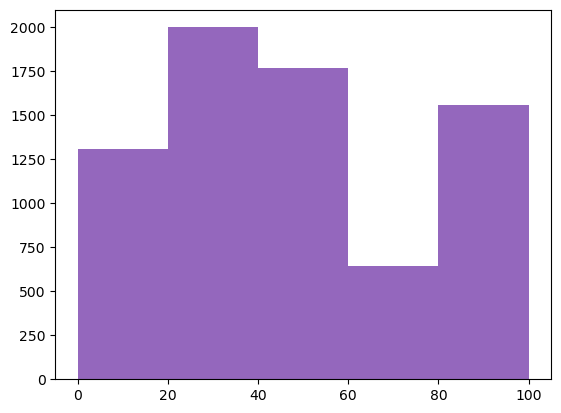

In [84]:
## Export Excel file for designer

df_export_all = []

for i in hist_list:
    counts, bins, bars = plt.hist(i.values, bins=5)
    df = pd.DataFrame({'bin_leftedge': bins[:-1], 'count': counts})
    df_export_all.append(df)
    

In [85]:
with pd.ExcelWriter(r''+dir_data+'/output/ForDesigner/Histograms_TargetedReductions_AllCompanies.xlsx') as writer:
    for i in range(len(legend_years)):
        df_export_all[i].to_excel(writer, sheet_name=legend_years[i])

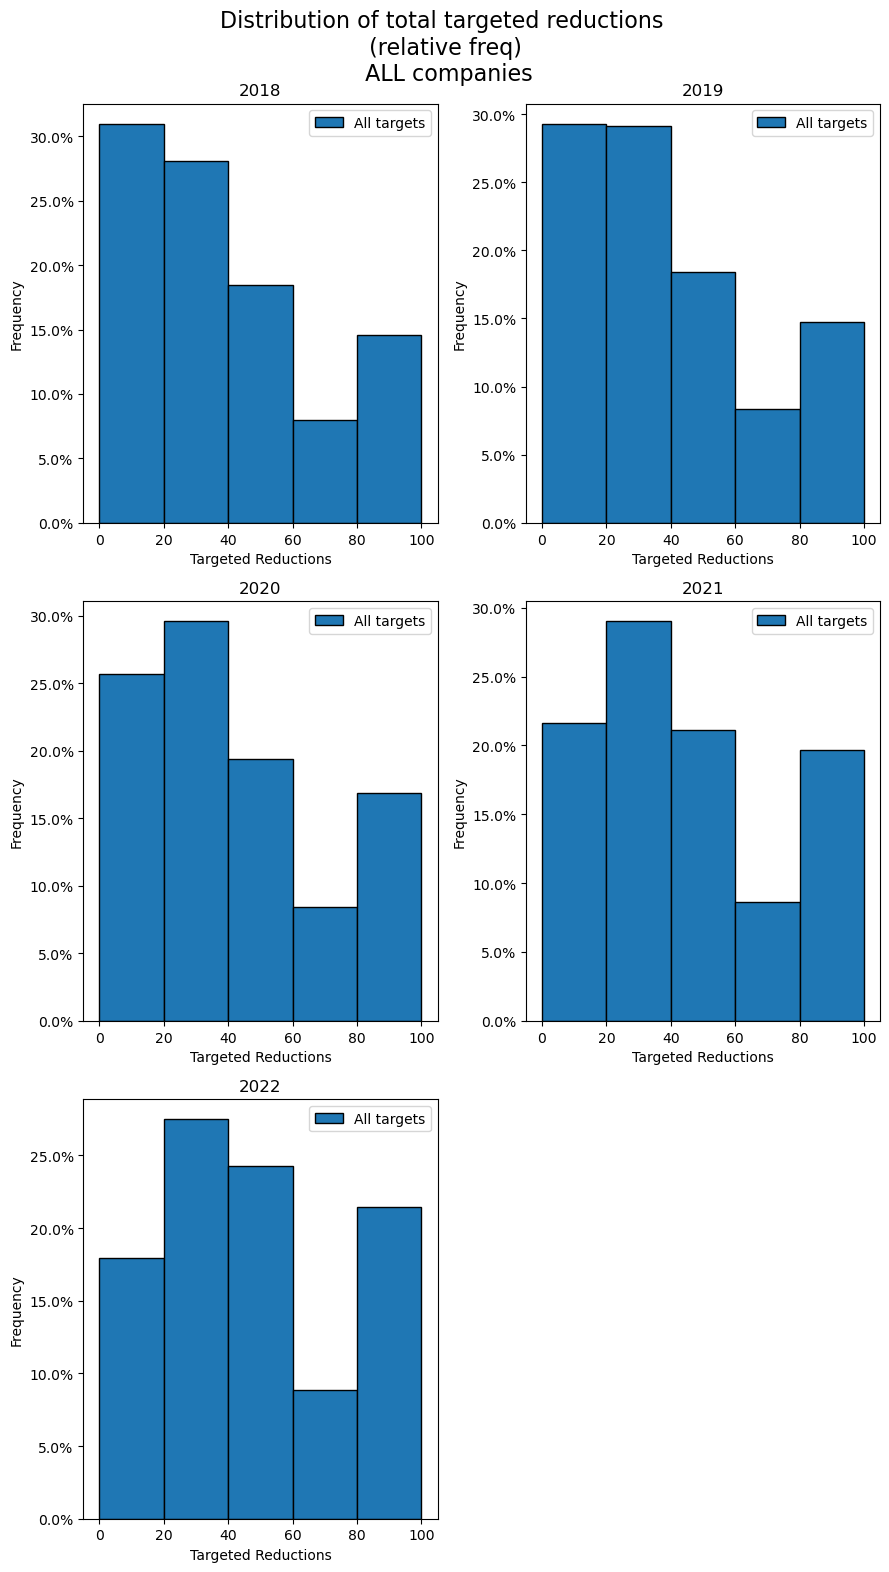

In [86]:
from matplotlib.ticker import PercentFormatter

figv = plt.figure(figsize=(9,16))    

ax1 = figv.add_subplot(321)
ax2 = figv.add_subplot(322)
ax3 = figv.add_subplot(323)
ax4 = figv.add_subplot(324)
ax5 = figv.add_subplot(325)

n_bins = 5
edge = 'black'

## Plotting all targets together, showing total frequencies
ax1.hist(x=hist_list[0], bins=n_bins, edgecolor=edge, weights=np.ones_like(hist_list[0])*100 / len(hist_list[0]))
ax1.set_title('2018')
ax1.yaxis.set_major_formatter(PercentFormatter())
ax2.hist(x=hist_list[1], bins=n_bins, edgecolor=edge, weights=np.ones_like(hist_list[1])*100 / len(hist_list[1]))
ax2.set_title('2019')
ax2.yaxis.set_major_formatter(PercentFormatter())
ax3.hist(x=hist_list[2], bins=n_bins, edgecolor=edge, weights=np.ones_like(hist_list[2])*100 / len(hist_list[2]))
ax3.set_title('2020')
ax3.yaxis.set_major_formatter(PercentFormatter())
ax4.hist(x=hist_list[3], bins=n_bins, edgecolor=edge, weights=np.ones_like(hist_list[3])*100 / len(hist_list[3]))
ax4.set_title('2021')
ax4.yaxis.set_major_formatter(PercentFormatter())
ax5.hist(x=hist_list[4],bins=n_bins, edgecolor=edge, weights=np.ones_like(hist_list[4])*100 / len(hist_list[4]))
ax5.set_title('2022')
ax5.yaxis.set_major_formatter(PercentFormatter())

for i in [ax1, ax2, ax3, ax4, ax5]:
    i.set_xlabel('Targeted Reductions')
    i.set_ylabel('Frequency')
    i.legend(labels=['All targets'])
    
figv.suptitle('Distribution of total targeted reductions \n (relative freq) \n ALL companies', fontsize=16)

figv.tight_layout()

if mry_calc == 'mry_standard':
    plt.savefig(r''+dir_data+'/output/Figures/TargetedReductions/TRSumRel_ALL_Histogram_MRYStandard.png')
elif mry_calc == 'mry_interpolate':
    plt.savefig(r''+dir_data+'/output/Figures/TargetedReductions/TRSumRel_ALL_Histogram_MRYInterpolation.png')
    
# if mry_calc == 'mry_standard':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/TR_ALL_Historgram_MRYStandard.png')
# elif mry_calc == 'mry_interpolate':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/TR_ALL_Historgram_MRYInterpolation.png')

C:\Users\Jones020\AppData\Local\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\Jones020\AppData\Local\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


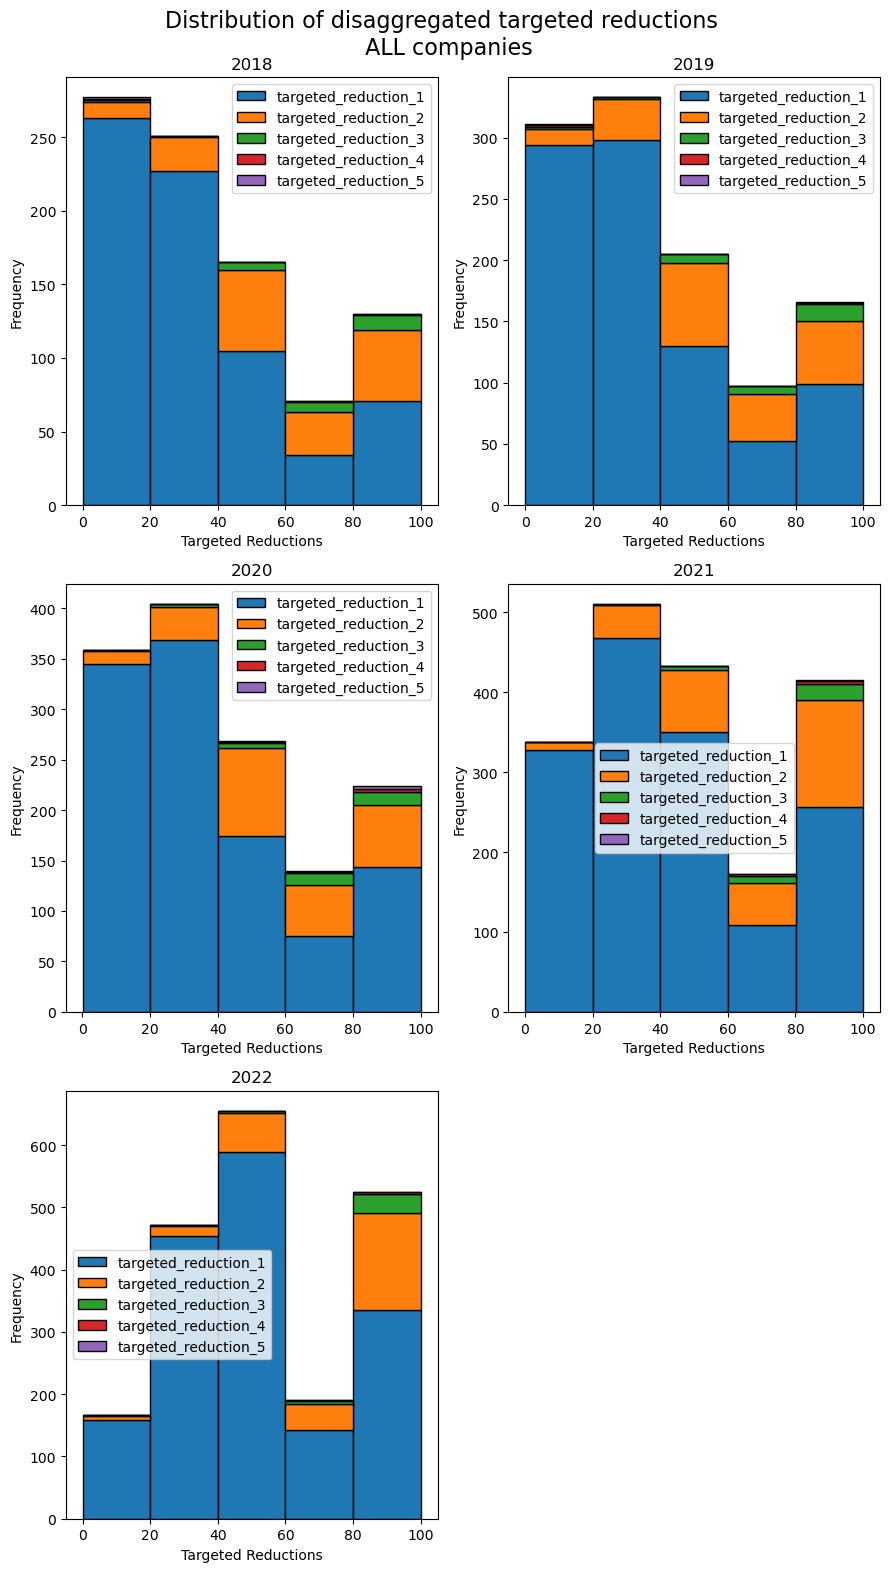

In [87]:
figx = plt.figure(figsize=(9,16))    

ax1 = figx.add_subplot(321)
ax2 = figx.add_subplot(322)
ax3 = figx.add_subplot(323)
ax4 = figx.add_subplot(324)
ax5 = figx.add_subplot(325)

n_bins = 5
edge = 'black'

## Plotting stacked version showing color coded frequencies of each target types (targeted_reduction_1, targeted_reduction_2, etc.)
ax1.hist(x=final_selections[0][targets], stacked=True, edgecolor=edge, bins=n_bins)
ax1.set_title('2018')
ax2.hist(x=final_selections[1][targets], stacked=True, edgecolor=edge, bins=n_bins)
ax2.set_title('2019')
ax3.hist(x=final_selections[2][targets], stacked=True, edgecolor=edge, bins=n_bins)
ax3.set_title('2020')
ax4.hist(x=final_selections[3][targets], stacked=True, edgecolor=edge, bins=n_bins)
ax4.set_title('2021')
ax5.hist(x=final_selections[4][targets], stacked=True, edgecolor=edge, bins=n_bins)
ax5.set_title('2022')

for i in [ax1, ax2, ax3, ax4, ax5]:
    i.set_xlabel('Targeted Reductions')
    i.set_ylabel('Frequency')
    i.legend(labels=targets)
    
figx.suptitle('Distribution of disaggregated targeted reductions \n ALL companies', fontsize=16)

figx.tight_layout()

if mry_calc == 'mry_standard':
    plt.savefig(r''+dir_data+'/output/Figures/TargetedReductions/TRStacked_ALL_Histogram_MRYStandard.png')
elif mry_calc == 'mry_interpolate':
    plt.savefig(r''+dir_data+'/output/Figures/TargetedReductions/TRStacked_ALL_Histogram_MRYInterpolation.png')

In [88]:
to_concat_2 = []

hist_list_2 = []

for i in overlapping_series:
    for t in targets:
        item = i[t]
        to_concat_2.append(item)
    concat_items = pd.concat(to_concat_2, axis=0).dropna()
    hist_list_2.append(concat_items)

<h4> Distribution of targeted reductions - OV companies </h4>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


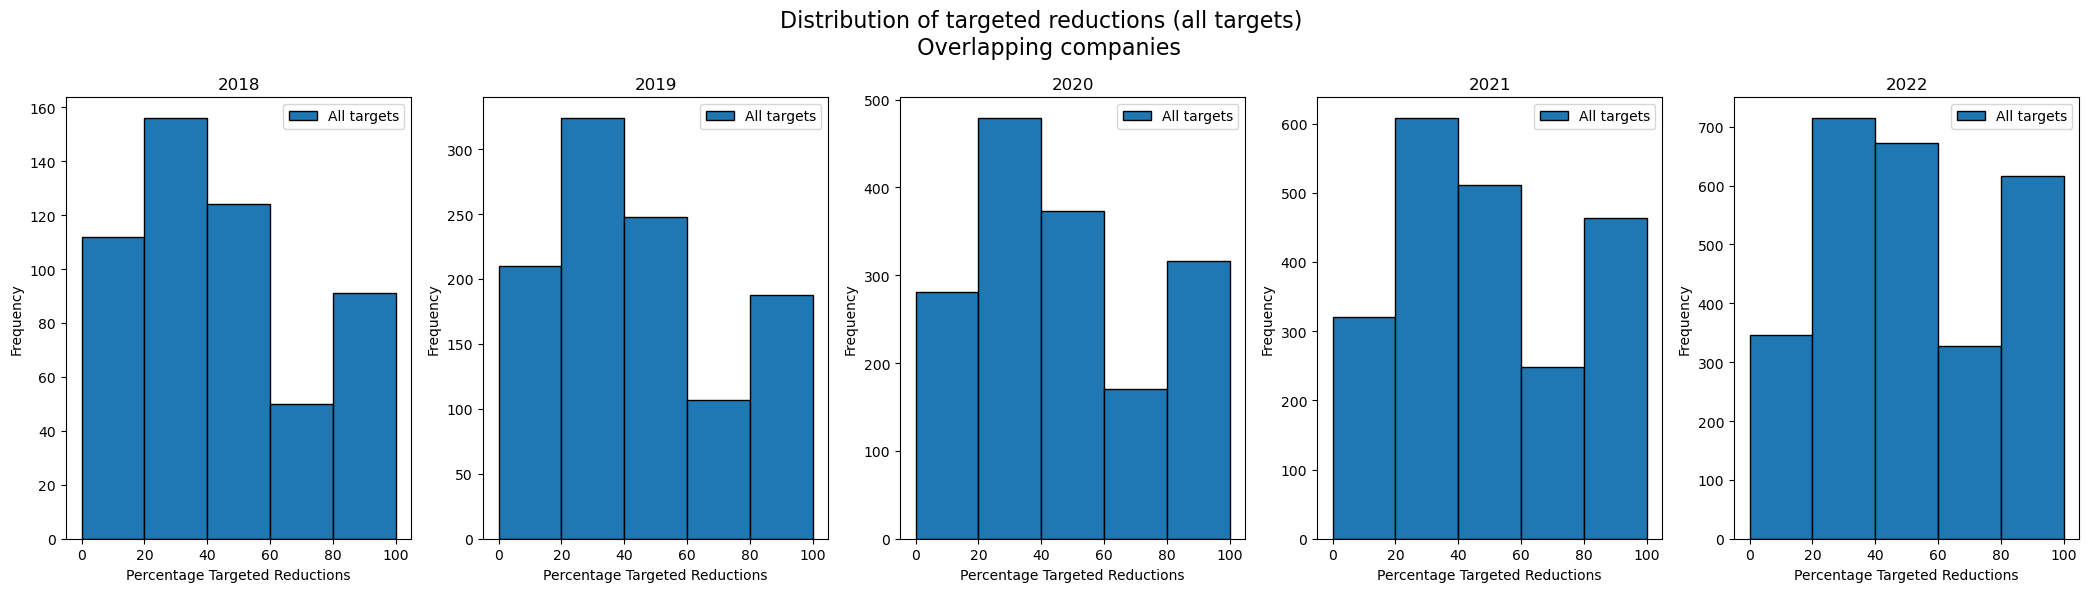

In [89]:
figy = plt.figure(figsize=(21,6))    

ax1 = figy.add_subplot(151)
ax2 = figy.add_subplot(152)
ax3 = figy.add_subplot(153)
ax4 = figy.add_subplot(154)
ax5 = figy.add_subplot(155)

n_bins = 5
edge = 'black'

## Plotting all targets together, showing total frequencies
ax1.hist(x=hist_list_2[0], bins=n_bins, edgecolor=edge)
ax1.set_title('2018')
ax2.hist(x=hist_list_2[1], bins=n_bins, edgecolor=edge)
ax2.set_title('2019')
ax3.hist(x=hist_list_2[2], bins=n_bins, edgecolor=edge)
ax3.set_title('2020')
ax4.hist(x=hist_list_2[3],bins=n_bins, edgecolor=edge)
ax4.set_title('2021')
ax5.hist(x=hist_list_2[4],bins=n_bins, edgecolor=edge)
ax5.set_title('2022')

for i in [ax1, ax2, ax3, ax4, ax5]:
    i.set_xlabel('Percentage Targeted Reductions')
    i.set_ylabel('Frequency')
    i.legend(labels=['All targets'])
    
figy.suptitle('Distribution of targeted reductions (all targets) \n Overlapping companies', fontsize=16)

figy.tight_layout()

if mry_calc == 'mry_standard':
    plt.savefig(r''+dir_data+'/output/Figures/TargetedReductions/TRSum_OV_Histogram_MRYStandard.png')
elif mry_calc == 'mry_interpolate':
    plt.savefig(r''+dir_data+'/output/Figures/TargetedReductions/TRSum_OV_Histogram_MRYInterpolation.png')
    plt.savefig(r''+dir_data+'/output/ForDesigner/Overlapping_Histogram.eps', format='eps')
    

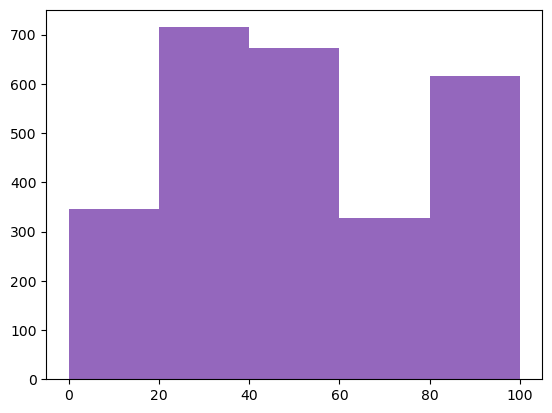

In [90]:
df_export_ov = []

for i in hist_list_2:
    counts, bins, bars = plt.hist(i.values, bins=5)
    df = pd.DataFrame({'bin_leftedge': bins[:-1], 'count': counts})
    df_export_ov.append(df)

In [91]:
with pd.ExcelWriter(r''+dir_data+'/output/ForDesigner/Histograms_TargetedReductions_OVCompanies.xlsx') as writer:
    for i in range(len(legend_years)):
        df_export_ov[i].to_excel(writer, sheet_name=legend_years[i])

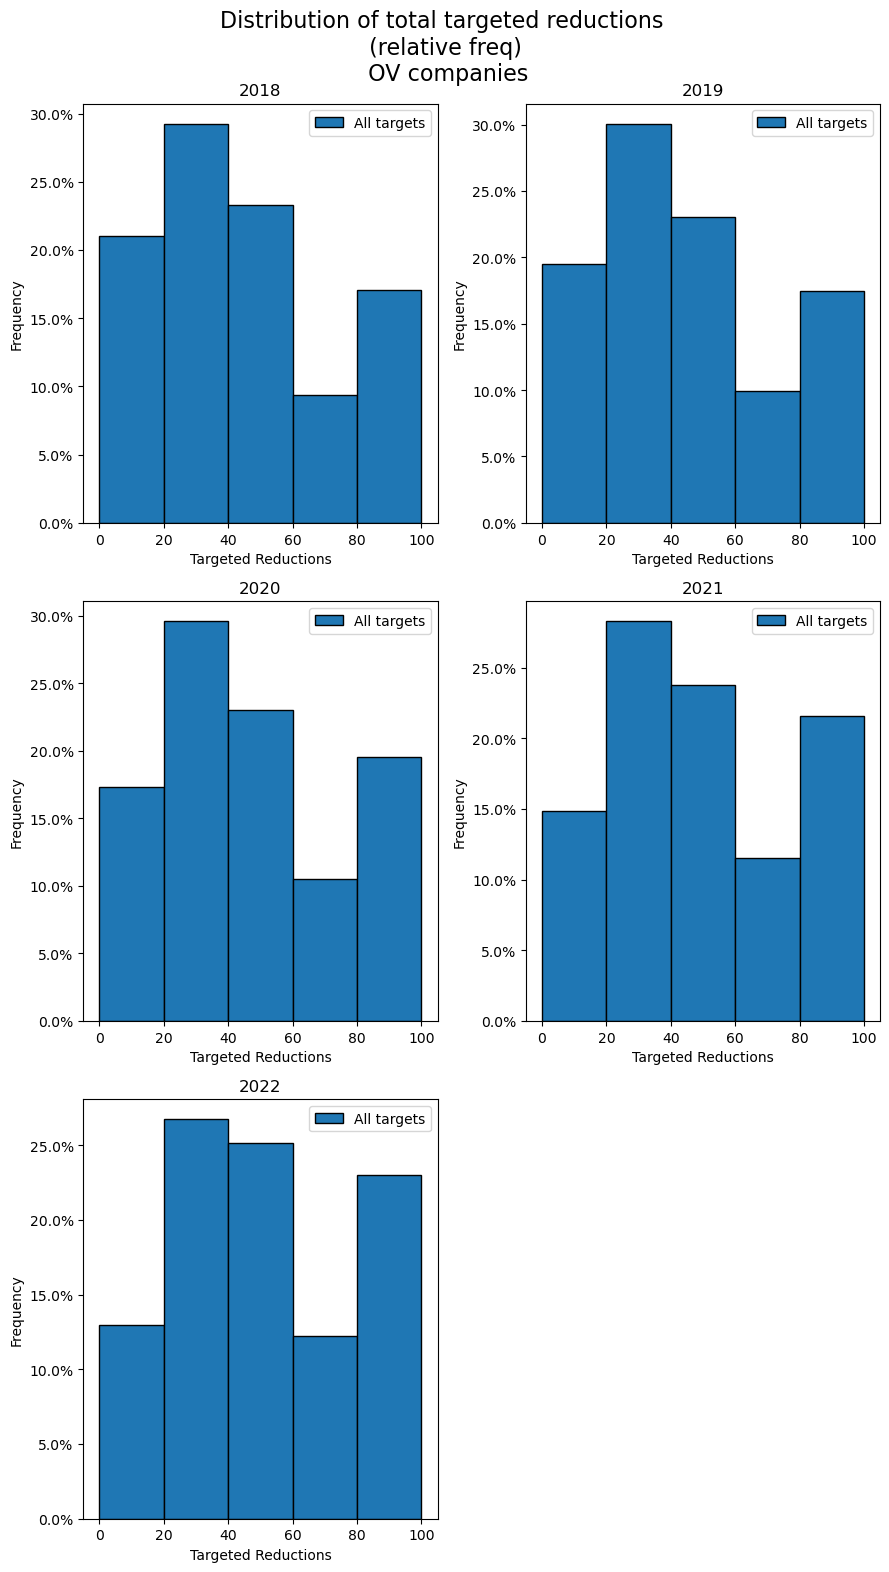

In [92]:
figz = plt.figure(figsize=(9,16))    

ax1 = figz.add_subplot(321)
ax2 = figz.add_subplot(322)
ax3 = figz.add_subplot(323)
ax4 = figz.add_subplot(324)
ax5 = figz.add_subplot(325)

n_bins = 5
edge = 'black'

## Plotting all targets together, showing total frequencies
ax1.hist(x=hist_list_2[0], bins=n_bins, edgecolor=edge, weights=np.ones_like(hist_list_2[0])*100 / len(hist_list_2[0]))
ax1.set_title('2018')
ax1.yaxis.set_major_formatter(PercentFormatter())
ax2.hist(x=hist_list_2[1], bins=n_bins, edgecolor=edge, weights=np.ones_like(hist_list_2[1])*100 / len(hist_list_2[1]))
ax2.set_title('2019')
ax2.yaxis.set_major_formatter(PercentFormatter())
ax3.hist(x=hist_list_2[2], bins=n_bins, edgecolor=edge, weights=np.ones_like(hist_list_2[2])*100 / len(hist_list_2[2]))
ax3.set_title('2020')
ax3.yaxis.set_major_formatter(PercentFormatter())
ax4.hist(x=hist_list_2[3], bins=n_bins, edgecolor=edge, weights=np.ones_like(hist_list_2[3])*100 / len(hist_list_2[3]))
ax4.set_title('2021')
ax4.yaxis.set_major_formatter(PercentFormatter())
ax5.hist(x=hist_list_2[4],bins=n_bins, edgecolor=edge, weights=np.ones_like(hist_list_2[4])*100 / len(hist_list_2[4]))
ax5.set_title('2022')
ax5.yaxis.set_major_formatter(PercentFormatter())

for i in [ax1, ax2, ax3, ax4, ax5]:
    i.set_xlabel('Targeted Reductions')
    i.set_ylabel('Frequency')
    i.legend(labels=['All targets'])
    
figz.suptitle('Distribution of total targeted reductions \n (relative freq) \n OV companies', fontsize=16)

figz.tight_layout()

if mry_calc == 'mry_standard':
    plt.savefig(r''+dir_data+'/output/Figures/TargetedReductions/TRSumRel_OV_Histogram_MRYStandard.png')
elif mry_calc == 'mry_interpolate':
    plt.savefig(r''+dir_data+'/output/Figures/TargetedReductions/TRSumRel_OV_Histogram_MRYInterpolation.png')

C:\Users\Jones020\AppData\Local\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\Jones020\AppData\Local\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
C:\Users\Jones020\AppData\Local\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\Jones020\AppData\Local\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


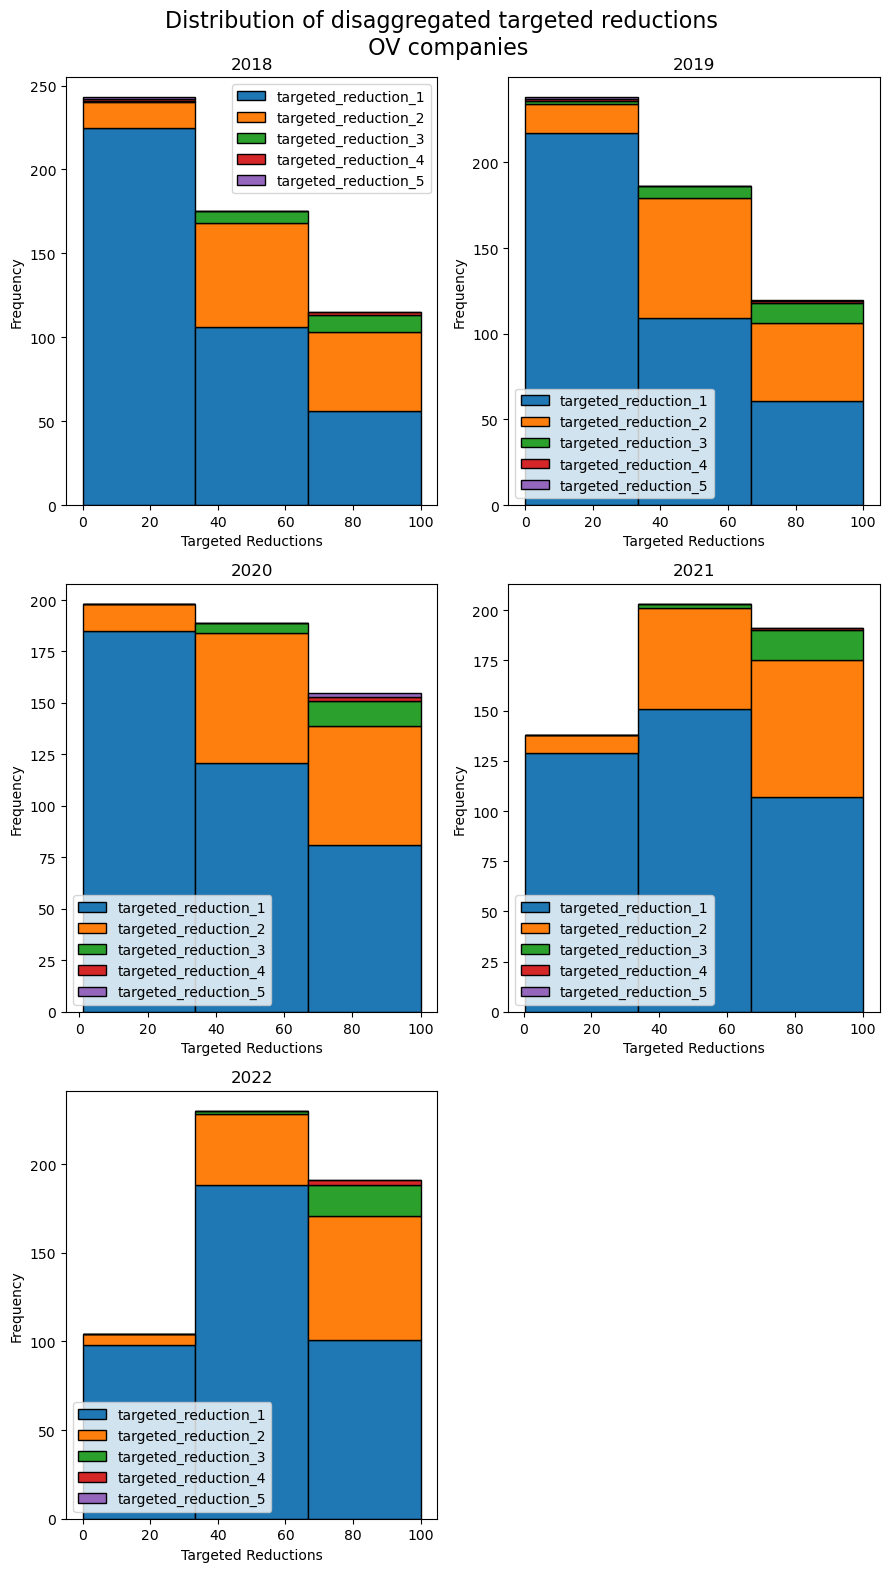

In [93]:
fig12 = plt.figure(figsize=(9,16))

ax1 = fig12.add_subplot(321)
ax2 = fig12.add_subplot(322)
ax3 = fig12.add_subplot(323)
ax4 = fig12.add_subplot(324)
ax5 = fig12.add_subplot(325)

n_bins= 3
eddge='black'

ax1.hist(x=overlapping_series[0][targets], edgecolor=edge, stacked=True, bins=n_bins)
ax1.set_title('2018')
ax2.hist(x=overlapping_series[1][targets], edgecolor=edge,  stacked=True, bins=n_bins)
ax2.set_title('2019')
ax3.hist(x=overlapping_series[2][targets], edgecolor=edge,  stacked=True, bins=n_bins)
ax3.set_title('2020')
ax4.hist(x=overlapping_series[3][targets], edgecolor=edge,  stacked=True, bins=n_bins)
ax4.set_title('2021')
ax5.hist(x=overlapping_series[4][targets], edgecolor=edge,  stacked=True, bins=n_bins)
ax5.set_title('2022')

for i in [ax1, ax2, ax3, ax4, ax5]:
    i.set_xlabel('Targeted Reductions')
    i.set_ylabel('Frequency')
    i.legend(labels=targets)
    
fig12.suptitle('Distribution of disaggregated targeted reductions \n OV companies', fontsize=16)

fig12.tight_layout()

if mry_calc == 'mry_standard':
    plt.savefig(r''+dir_data+'/output/Figures/TargetedReductions/TRStacked_OV_Histogram_MRYStandard.png')
elif mry_calc == 'mry_interpolate':
    plt.savefig(r''+dir_data+'/output/Figures/TargetedReductions/TRStacked_OV_Histogram_MRYInterpolation.png')
    
# if mry_calc == 'mry_standard':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/TR_OV_Historgram_MRYStandard.png')
# elif mry_calc == 'mry_interpolate':
#     plt.savefig(r''+dir_data+'/output/OLD/Figures/TR_OV_Historgram_MRYInterpolation.png')